In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 73 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.

In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 393 (delta 183), reused 310 (delta 103), pack-reused 0
Receiving objects: 100% (393/393), 49.42 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6379, done.
remote: Counting objects: 100% (881/881), done.
remote: Compressing objects: 100% (491/491), done.
remote: Total 6379 (delta 525), reused 585 (delta 382), pack-reused 5498
Receiving objects: 100% (6379/6379), 13.21 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (4557/4557), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf ToTrain/
!unzip ../../ToTrain.zip

Archive:  ../../ToTrain.zip
   creating: ToTrain/
   creating: ToTrain/annotations/
  inflating: ToTrain/annotations/image020-roi1.tif  
  inflating: ToTrain/annotations/image008-roi1.tif  
  inflating: ToTrain/annotations/image032-roi1.tif  
  inflating: ToTrain/annotations/image019-roi2.tif  
  inflating: ToTrain/annotations/image019-roi5.tif  
  inflating: ToTrain/annotations/image058-roi5.tif  
  inflating: ToTrain/annotations/image038-roi4.tif  
  inflating: ToTrain/annotations/image058-roi1.tif  
  inflating: ToTrain/annotations/image021-roi3.tif  
  inflating: ToTrain/annotations/image006-roi2.tif  
  inflating: ToTrain/annotations/image021-roi6.tif  
  inflating: ToTrain/annotations/image038-roi1.tif  
  inflating: ToTrain/annotations/image003-2-roi3.tif  
  inflating: ToTrain/annotations/image038-roi3.tif  
  inflating: ToTrain/annotations/image039-roi3.tif  
  inflating: ToTrain/annotations/image017-roi1.tif  
  inflating: ToTrain/annotations/image004-roi2.tif  
  inflating: 

In [6]:
data_root = 'ToTrain'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

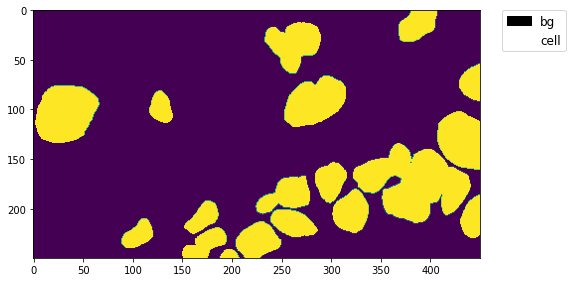

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('ToTrain/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.tif', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet.py')

In [12]:
cfg.runner.max_epochs = 150
cfg.work_dir = './work_dirs/psp_150'
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'ToTrain'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='Resize

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-03-05 17:09:16,668 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-03-05 17:09:19,731 - mmseg - INFO - Loaded 24 images
2022-03-05 17:09:19,733 - mmseg - INFO - Start running, host: root@bc4fbabc8ab9, work_dir: /content/tcc/mmsegmentation/work_dirs/psp_150
2022-03-05 17:09:19,738 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(V

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-05 17:09:42,190 - mmseg - INFO - per class results:
2022-03-05 17:09:42,193 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.68 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-03-05 17:09:42,196 - mmseg - INFO - Summary:
2022-03-05 17:09:42,199 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 67.61 | 40.34 | 50.0 |
+-------+-------+------+
2022-03-05 17:09:42,203 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6761, mDice: 0.4034, mAcc: 0.5000, Dice.bg: 0.8068, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-03-05 17:10:01,074 - mmseg - INFO - Epoch [2][12/12]	lr: 9.941e-03, eta: 0:46:30, time: 1.561, data_time: 0.187, memory: 3768, decode.loss_ce: 0.5037, decode.acc_seg: 52.7014, aux.loss_ce: 0.2004, aux.acc_seg: 53.2439, loss: 0.7041


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:10:03,304 - mmseg - INFO - per class results:
2022-03-05 17:10:03,307 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.91 | 96.95 |
|  cell | 18.55 | 10.87 |
+-------+-------+-------+
2022-03-05 17:10:03,309 - mmseg - INFO - Summary:
2022-03-05 17:10:03,313 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 69.07 | 49.73 | 53.91 |
+-------+-------+-------+
2022-03-05 17:10:03,317 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.6907, mDice: 0.4973, mAcc: 0.5391, Dice.bg: 0.8091, Dice.cell: 0.1855, Acc.bg: 0.9695, Acc.cell: 0.1087
2022-03-05 17:10:21,985 - mmseg - INFO - Epoch [3][12/12]	lr: 9.881e-03, eta: 0:45:55, time: 1.544, data_time: 0.180, memory: 3768, decode.loss_ce: 0.4837, decode.acc_seg: 54.6206, aux.loss_ce: 0.1906, aux.acc_seg: 55.3532, loss: 0.6743


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:10:24,208 - mmseg - INFO - per class results:
2022-03-05 17:10:24,212 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.34 | 90.63 |
|  cell | 36.82 | 26.98 |
+-------+-------+-------+
2022-03-05 17:10:24,213 - mmseg - INFO - Summary:
2022-03-05 17:10:24,219 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 70.02 | 58.58 | 58.81 |
+-------+-------+-------+
2022-03-05 17:10:24,221 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7002, mDice: 0.5858, mAcc: 0.5881, Dice.bg: 0.8034, Dice.cell: 0.3682, Acc.bg: 0.9063, Acc.cell: 0.2698
2022-03-05 17:10:42,974 - mmseg - INFO - Epoch [4][12/12]	lr: 9.822e-03, eta: 0:45:31, time: 1.550, data_time: 0.189, memory: 3768, decode.loss_ce: 0.4430, decode.acc_seg: 54.1543, aux.loss_ce: 0.1759, aux.acc_seg: 54.3850, loss: 0.6188


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:10:45,210 - mmseg - INFO - per class results:
2022-03-05 17:10:45,213 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.29 | 96.43 |
|  cell | 32.45 | 20.81 |
+-------+-------+-------+
2022-03-05 17:10:45,216 - mmseg - INFO - Summary:
2022-03-05 17:10:45,218 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 71.94 | 57.37 | 58.62 |
+-------+-------+-------+
2022-03-05 17:10:45,220 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7194, mDice: 0.5737, mAcc: 0.5862, Dice.bg: 0.8229, Dice.cell: 0.3245, Acc.bg: 0.9643, Acc.cell: 0.2081
2022-03-05 17:11:03,960 - mmseg - INFO - Epoch [5][12/12]	lr: 9.762e-03, eta: 0:45:09, time: 1.550, data_time: 0.188, memory: 3768, decode.loss_ce: 0.4272, decode.acc_seg: 56.6358, aux.loss_ce: 0.1720, aux.acc_seg: 56.5556, loss: 0.5992


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.0 task/s, elapsed: 3s, ETA:     0s

2022-03-05 17:11:06,651 - mmseg - INFO - per class results:
2022-03-05 17:11:06,654 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.32 | 83.38 |
|  cell |  57.8 | 54.75 |
+-------+-------+-------+
2022-03-05 17:11:06,655 - mmseg - INFO - Summary:
2022-03-05 17:11:06,658 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 74.1 | 69.56 | 69.06 |
+------+-------+-------+
2022-03-05 17:11:06,663 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7410, mDice: 0.6956, mAcc: 0.6906, Dice.bg: 0.8132, Dice.cell: 0.5780, Acc.bg: 0.8338, Acc.cell: 0.5475
2022-03-05 17:11:25,405 - mmseg - INFO - Epoch [6][12/12]	lr: 9.702e-03, eta: 0:44:48, time: 1.550, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3836, decode.acc_seg: 55.9732, aux.loss_ce: 0.1574, aux.acc_seg: 55.6847, loss: 0.5411


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:11:27,639 - mmseg - INFO - per class results:
2022-03-05 17:11:27,640 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 77.42 | 70.63 |
|  cell | 63.64 | 75.27 |
+-------+-------+-------+
2022-03-05 17:11:27,645 - mmseg - INFO - Summary:
2022-03-05 17:11:27,648 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 72.14 | 70.53 | 72.95 |
+-------+-------+-------+
2022-03-05 17:11:27,651 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.7214, mDice: 0.7053, mAcc: 0.7295, Dice.bg: 0.7742, Dice.cell: 0.6364, Acc.bg: 0.7063, Acc.cell: 0.7527
2022-03-05 17:11:46,361 - mmseg - INFO - Epoch [7][12/12]	lr: 9.643e-03, eta: 0:44:28, time: 1.547, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3924, decode.acc_seg: 59.7881, aux.loss_ce: 0.1603, aux.acc_seg: 59.3901, loss: 0.5527


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:11:48,590 - mmseg - INFO - per class results:
2022-03-05 17:11:48,593 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.33 | 76.01 |
|  cell | 65.06 | 72.36 |
+-------+-------+-------+
2022-03-05 17:11:48,597 - mmseg - INFO - Summary:
2022-03-05 17:11:48,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.83 |  72.7 | 74.19 |
+-------+-------+-------+
2022-03-05 17:11:48,602 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.7483, mDice: 0.7270, mAcc: 0.7419, Dice.bg: 0.8033, Dice.cell: 0.6506, Acc.bg: 0.7601, Acc.cell: 0.7236
2022-03-05 17:12:07,302 - mmseg - INFO - Epoch [8][12/12]	lr: 9.583e-03, eta: 0:44:07, time: 1.546, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3714, decode.acc_seg: 57.3775, aux.loss_ce: 0.1519, aux.acc_seg: 56.5791, loss: 0.5233


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:12:09,515 - mmseg - INFO - per class results:
2022-03-05 17:12:09,519 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.46 | 82.49 |
|  cell | 63.33 | 63.28 |
+-------+-------+-------+
2022-03-05 17:12:09,522 - mmseg - INFO - Summary:
2022-03-05 17:12:09,524 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.27 |  72.9 | 72.89 |
+-------+-------+-------+
2022-03-05 17:12:09,528 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.7627, mDice: 0.7290, mAcc: 0.7289, Dice.bg: 0.8246, Dice.cell: 0.6333, Acc.bg: 0.8249, Acc.cell: 0.6328
2022-03-05 17:12:28,310 - mmseg - INFO - Epoch [9][12/12]	lr: 9.524e-03, eta: 0:43:48, time: 1.553, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3785, decode.acc_seg: 61.9452, aux.loss_ce: 0.1521, aux.acc_seg: 61.8753, loss: 0.5306


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:12:30,535 - mmseg - INFO - per class results:
2022-03-05 17:12:30,538 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.57 | 77.59 |
|  cell | 66.79 | 73.59 |
+-------+-------+-------+
2022-03-05 17:12:30,540 - mmseg - INFO - Summary:
2022-03-05 17:12:30,546 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 76.3 | 74.18 | 75.59 |
+------+-------+-------+
2022-03-05 17:12:30,548 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.7630, mDice: 0.7418, mAcc: 0.7559, Dice.bg: 0.8157, Dice.cell: 0.6679, Acc.bg: 0.7759, Acc.cell: 0.7359
2022-03-05 17:12:49,242 - mmseg - INFO - Epoch [10][12/12]	lr: 9.464e-03, eta: 0:43:28, time: 1.546, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3720, decode.acc_seg: 59.9657, aux.loss_ce: 0.1493, aux.acc_seg: 59.9586, loss: 0.5213
2022-03-05 17:12:49,245 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:12:54,189 - mmseg - INFO - per class results:
2022-03-05 17:12:54,192 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  83.7 | 83.16 |
|  cell | 66.64 | 67.54 |
+-------+-------+-------+
2022-03-05 17:12:54,193 - mmseg - INFO - Summary:
2022-03-05 17:12:54,196 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 78.1 | 75.17 | 75.35 |
+------+-------+-------+
2022-03-05 17:12:54,205 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.7810, mDice: 0.7517, mAcc: 0.7535, Dice.bg: 0.8370, Dice.cell: 0.6664, Acc.bg: 0.8316, Acc.cell: 0.6754
2022-03-05 17:13:12,866 - mmseg - INFO - Epoch [11][12/12]	lr: 9.404e-03, eta: 0:43:08, time: 1.543, data_time: 0.183, memory: 3768, decode.loss_ce: 0.3563, decode.acc_seg: 61.6390, aux.loss_ce: 0.1461, aux.acc_seg: 61.0926, loss: 0.5023


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:13:15,082 - mmseg - INFO - per class results:
2022-03-05 17:13:15,093 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.07 | 80.48 |
|  cell | 67.84 | 72.24 |
+-------+-------+-------+
2022-03-05 17:13:15,094 - mmseg - INFO - Summary:
2022-03-05 17:13:15,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.81 | 75.45 | 76.36 |
+-------+-------+-------+
2022-03-05 17:13:15,102 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.7781, mDice: 0.7545, mAcc: 0.7636, Dice.bg: 0.8307, Dice.cell: 0.6784, Acc.bg: 0.8048, Acc.cell: 0.7224
2022-03-05 17:13:33,756 - mmseg - INFO - Epoch [12][12/12]	lr: 9.344e-03, eta: 0:42:48, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3579, decode.acc_seg: 63.2395, aux.loss_ce: 0.1480, aux.acc_seg: 62.6494, loss: 0.5059


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:13:35,967 - mmseg - INFO - per class results:
2022-03-05 17:13:35,970 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.18 | 78.31 |
|  cell | 67.72 | 74.37 |
+-------+-------+-------+
2022-03-05 17:13:35,973 - mmseg - INFO - Summary:
2022-03-05 17:13:35,976 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.04 | 74.95 | 76.34 |
+-------+-------+-------+
2022-03-05 17:13:35,979 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.7704, mDice: 0.7495, mAcc: 0.7634, Dice.bg: 0.8218, Dice.cell: 0.6772, Acc.bg: 0.7831, Acc.cell: 0.7437
2022-03-05 17:13:54,682 - mmseg - INFO - Epoch [13][12/12]	lr: 9.284e-03, eta: 0:42:29, time: 1.547, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3809, decode.acc_seg: 65.8115, aux.loss_ce: 0.1549, aux.acc_seg: 65.2184, loss: 0.5358


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:13:56,896 - mmseg - INFO - per class results:
2022-03-05 17:13:56,898 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.17 | 80.18 |
|  cell | 68.49 | 73.62 |
+-------+-------+-------+
2022-03-05 17:13:56,901 - mmseg - INFO - Summary:
2022-03-05 17:13:56,907 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.06 | 75.83 | 76.9 |
+-------+-------+------+
2022-03-05 17:13:56,912 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.7806, mDice: 0.7583, mAcc: 0.7690, Dice.bg: 0.8317, Dice.cell: 0.6849, Acc.bg: 0.8018, Acc.cell: 0.7362
2022-03-05 17:14:15,669 - mmseg - INFO - Epoch [14][12/12]	lr: 9.224e-03, eta: 0:42:11, time: 1.551, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3526, decode.acc_seg: 59.5985, aux.loss_ce: 0.1417, aux.acc_seg: 59.5082, loss: 0.4942


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:14:17,893 - mmseg - INFO - per class results:
2022-03-05 17:14:17,895 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.94 | 86.01 |
|  cell | 67.31 | 65.54 |
+-------+-------+-------+
2022-03-05 17:14:17,897 - mmseg - INFO - Summary:
2022-03-05 17:14:17,907 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.38 | 76.13 | 75.78 |
+-------+-------+-------+
2022-03-05 17:14:17,908 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.7938, mDice: 0.7613, mAcc: 0.7578, Dice.bg: 0.8494, Dice.cell: 0.6731, Acc.bg: 0.8601, Acc.cell: 0.6554
2022-03-05 17:14:36,651 - mmseg - INFO - Epoch [15][12/12]	lr: 9.164e-03, eta: 0:41:52, time: 1.550, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3388, decode.acc_seg: 58.1102, aux.loss_ce: 0.1351, aux.acc_seg: 58.0381, loss: 0.4739


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:14:38,875 - mmseg - INFO - per class results:
2022-03-05 17:14:38,878 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.85 | 84.15 |
|  cell | 69.17 | 70.36 |
+-------+-------+-------+
2022-03-05 17:14:38,880 - mmseg - INFO - Summary:
2022-03-05 17:14:38,891 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.69 | 77.01 | 77.26 |
+-------+-------+-------+
2022-03-05 17:14:38,894 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.7969, mDice: 0.7701, mAcc: 0.7726, Dice.bg: 0.8485, Dice.cell: 0.6917, Acc.bg: 0.8415, Acc.cell: 0.7036
2022-03-05 17:14:57,625 - mmseg - INFO - Epoch [16][12/12]	lr: 9.104e-03, eta: 0:41:33, time: 1.549, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3488, decode.acc_seg: 61.1792, aux.loss_ce: 0.1416, aux.acc_seg: 61.0215, loss: 0.4904


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:14:59,833 - mmseg - INFO - per class results:
2022-03-05 17:14:59,835 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.61 | 87.63 |
|  cell | 67.66 | 64.33 |
+-------+-------+-------+
2022-03-05 17:14:59,837 - mmseg - INFO - Summary:
2022-03-05 17:14:59,840 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.08 | 76.63 | 75.98 |
+-------+-------+-------+
2022-03-05 17:14:59,850 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.8008, mDice: 0.7663, mAcc: 0.7598, Dice.bg: 0.8561, Dice.cell: 0.6766, Acc.bg: 0.8763, Acc.cell: 0.6433
2022-03-05 17:15:18,523 - mmseg - INFO - Epoch [17][12/12]	lr: 9.044e-03, eta: 0:41:14, time: 1.544, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3413, decode.acc_seg: 63.7785, aux.loss_ce: 0.1405, aux.acc_seg: 63.3476, loss: 0.4818


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:15:20,749 - mmseg - INFO - per class results:
2022-03-05 17:15:20,752 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.63 | 90.96 |
|  cell | 63.37 | 55.13 |
+-------+-------+-------+
2022-03-05 17:15:20,755 - mmseg - INFO - Summary:
2022-03-05 17:15:20,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.35 |  74.5 | 73.04 |
+-------+-------+-------+
2022-03-05 17:15:20,759 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.7935, mDice: 0.7450, mAcc: 0.7304, Dice.bg: 0.8563, Dice.cell: 0.6337, Acc.bg: 0.9096, Acc.cell: 0.5513
2022-03-05 17:15:39,441 - mmseg - INFO - Epoch [18][12/12]	lr: 8.984e-03, eta: 0:40:55, time: 1.545, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3451, decode.acc_seg: 62.9879, aux.loss_ce: 0.1425, aux.acc_seg: 62.5016, loss: 0.4876


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:15:41,649 - mmseg - INFO - per class results:
2022-03-05 17:15:41,653 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.09 | 78.87 |
|  cell |  69.7 | 77.09 |
+-------+-------+-------+
2022-03-05 17:15:41,655 - mmseg - INFO - Summary:
2022-03-05 17:15:41,657 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.29 | 76.39 | 77.98 |
+-------+-------+-------+
2022-03-05 17:15:41,669 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.7829, mDice: 0.7639, mAcc: 0.7798, Dice.bg: 0.8309, Dice.cell: 0.6970, Acc.bg: 0.7887, Acc.cell: 0.7709
2022-03-05 17:16:00,402 - mmseg - INFO - Epoch [19][12/12]	lr: 8.924e-03, eta: 0:40:36, time: 1.549, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3482, decode.acc_seg: 62.0526, aux.loss_ce: 0.1417, aux.acc_seg: 61.6494, loss: 0.4899


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:16:02,609 - mmseg - INFO - per class results:
2022-03-05 17:16:02,611 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.88 | 87.92 |
|  cell | 68.24 | 64.85 |
+-------+-------+-------+
2022-03-05 17:16:02,613 - mmseg - INFO - Summary:
2022-03-05 17:16:02,616 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.45 | 77.06 | 76.38 |
+-------+-------+-------+
2022-03-05 17:16:02,622 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.8045, mDice: 0.7706, mAcc: 0.7638, Dice.bg: 0.8588, Dice.cell: 0.6824, Acc.bg: 0.8792, Acc.cell: 0.6485
2022-03-05 17:16:21,341 - mmseg - INFO - Epoch [20][12/12]	lr: 8.864e-03, eta: 0:40:18, time: 1.548, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3327, decode.acc_seg: 63.9466, aux.loss_ce: 0.1371, aux.acc_seg: 63.4942, loss: 0.4698
2022-03-05 17:16:21,349 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:16:25,525 - mmseg - INFO - per class results:
2022-03-05 17:16:25,529 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.61 | 86.02 |
|  cell | 69.52 | 68.83 |
+-------+-------+-------+
2022-03-05 17:16:25,532 - mmseg - INFO - Summary:
2022-03-05 17:16:25,534 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.45 | 77.57 | 77.43 |
+-------+-------+-------+
2022-03-05 17:16:25,537 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.8045, mDice: 0.7757, mAcc: 0.7743, Dice.bg: 0.8561, Dice.cell: 0.6952, Acc.bg: 0.8602, Acc.cell: 0.6883
2022-03-05 17:16:44,251 - mmseg - INFO - Epoch [21][12/12]	lr: 8.804e-03, eta: 0:39:59, time: 1.548, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3335, decode.acc_seg: 63.3615, aux.loss_ce: 0.1360, aux.acc_seg: 62.9562, loss: 0.4694


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:16:46,478 - mmseg - INFO - per class results:
2022-03-05 17:16:46,481 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.39 | 80.95 |
|  cell | 71.21 | 77.28 |
+-------+-------+-------+
2022-03-05 17:16:46,483 - mmseg - INFO - Summary:
2022-03-05 17:16:46,486 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.76 |  77.8 | 79.11 |
+-------+-------+-------+
2022-03-05 17:16:46,489 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.7976, mDice: 0.7780, mAcc: 0.7911, Dice.bg: 0.8439, Dice.cell: 0.7121, Acc.bg: 0.8095, Acc.cell: 0.7728
2022-03-05 17:17:05,239 - mmseg - INFO - Epoch [22][12/12]	lr: 8.743e-03, eta: 0:39:40, time: 1.551, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3415, decode.acc_seg: 62.1164, aux.loss_ce: 0.1382, aux.acc_seg: 61.9658, loss: 0.4796


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:17:07,449 - mmseg - INFO - per class results:
2022-03-05 17:17:07,452 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.61 | 73.42 |
|  cell | 68.92 | 81.76 |
+-------+-------+-------+
2022-03-05 17:17:07,455 - mmseg - INFO - Summary:
2022-03-05 17:17:07,457 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.12 | 74.76 | 77.59 |
+-------+-------+-------+
2022-03-05 17:17:07,468 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.7612, mDice: 0.7476, mAcc: 0.7759, Dice.bg: 0.8061, Dice.cell: 0.6892, Acc.bg: 0.7342, Acc.cell: 0.8176
2022-03-05 17:17:26,269 - mmseg - INFO - Epoch [23][12/12]	lr: 8.683e-03, eta: 0:39:22, time: 1.555, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3249, decode.acc_seg: 60.9839, aux.loss_ce: 0.1320, aux.acc_seg: 60.6149, loss: 0.4569


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:17:28,483 - mmseg - INFO - per class results:
2022-03-05 17:17:28,489 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.6 | 84.75 |
|  cell | 70.84 |  72.3 |
+-------+-------+-------+
2022-03-05 17:17:28,495 - mmseg - INFO - Summary:
2022-03-05 17:17:28,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.72 | 78.22 | 78.53 |
+-------+-------+-------+
2022-03-05 17:17:28,501 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.8072, mDice: 0.7822, mAcc: 0.7853, Dice.bg: 0.8560, Dice.cell: 0.7084, Acc.bg: 0.8475, Acc.cell: 0.7230
2022-03-05 17:17:47,159 - mmseg - INFO - Epoch [24][12/12]	lr: 8.623e-03, eta: 0:39:03, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3195, decode.acc_seg: 64.1899, aux.loss_ce: 0.1311, aux.acc_seg: 63.6458, loss: 0.4506


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:17:49,376 - mmseg - INFO - per class results:
2022-03-05 17:17:49,382 - mmseg - INFO - 
+-------+------+-------+
| Class | Dice |  Acc  |
+-------+------+-------+
|   bg  | 85.6 |  84.3 |
|  cell | 71.3 | 73.56 |
+-------+------+-------+
2022-03-05 17:17:49,387 - mmseg - INFO - Summary:
2022-03-05 17:17:49,389 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.82 | 78.45 | 78.93 |
+-------+-------+-------+
2022-03-05 17:17:49,391 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.8082, mDice: 0.7845, mAcc: 0.7893, Dice.bg: 0.8560, Dice.cell: 0.7130, Acc.bg: 0.8430, Acc.cell: 0.7356
2022-03-05 17:18:08,140 - mmseg - INFO - Epoch [25][12/12]	lr: 8.562e-03, eta: 0:38:44, time: 1.551, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3226, decode.acc_seg: 64.6379, aux.loss_ce: 0.1333, aux.acc_seg: 64.0275, loss: 0.4559


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:18:10,369 - mmseg - INFO - per class results:
2022-03-05 17:18:10,371 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.68 | 84.64 |
|  cell | 71.21 | 73.03 |
+-------+-------+-------+
2022-03-05 17:18:10,379 - mmseg - INFO - Summary:
2022-03-05 17:18:10,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.88 | 78.45 | 78.83 |
+-------+-------+-------+
2022-03-05 17:18:10,384 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8088, mDice: 0.7845, mAcc: 0.7883, Dice.bg: 0.8568, Dice.cell: 0.7121, Acc.bg: 0.8464, Acc.cell: 0.7303
2022-03-05 17:18:29,082 - mmseg - INFO - Epoch [26][12/12]	lr: 8.502e-03, eta: 0:38:26, time: 1.546, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3335, decode.acc_seg: 64.2372, aux.loss_ce: 0.1369, aux.acc_seg: 63.6966, loss: 0.4704


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:18:31,306 - mmseg - INFO - per class results:
2022-03-05 17:18:31,310 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.42 |  83.6 |
|  cell |  71.5 | 74.68 |
+-------+-------+-------+
2022-03-05 17:18:31,313 - mmseg - INFO - Summary:
2022-03-05 17:18:31,316 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.71 | 78.46 | 79.14 |
+-------+-------+-------+
2022-03-05 17:18:31,318 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8071, mDice: 0.7846, mAcc: 0.7914, Dice.bg: 0.8542, Dice.cell: 0.7150, Acc.bg: 0.8360, Acc.cell: 0.7468
2022-03-05 17:18:50,027 - mmseg - INFO - Epoch [27][12/12]	lr: 8.441e-03, eta: 0:38:07, time: 1.547, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3378, decode.acc_seg: 65.8363, aux.loss_ce: 0.1385, aux.acc_seg: 65.3576, loss: 0.4763


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:18:52,265 - mmseg - INFO - per class results:
2022-03-05 17:18:52,267 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.43 | 75.85 |
|  cell | 71.08 | 82.93 |
+-------+-------+-------+
2022-03-05 17:18:52,273 - mmseg - INFO - Summary:
2022-03-05 17:18:52,275 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.14 | 76.76 | 79.39 |
+-------+-------+-------+
2022-03-05 17:18:52,278 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.7814, mDice: 0.7676, mAcc: 0.7939, Dice.bg: 0.8243, Dice.cell: 0.7108, Acc.bg: 0.7585, Acc.cell: 0.8293
2022-03-05 17:19:10,981 - mmseg - INFO - Epoch [28][12/12]	lr: 8.381e-03, eta: 0:37:48, time: 1.547, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3224, decode.acc_seg: 61.8566, aux.loss_ce: 0.1299, aux.acc_seg: 61.6843, loss: 0.4522


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:19:13,202 - mmseg - INFO - per class results:
2022-03-05 17:19:13,207 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.53 | 89.86 |
|  cell | 68.24 | 62.75 |
+-------+-------+-------+
2022-03-05 17:19:13,211 - mmseg - INFO - Summary:
2022-03-05 17:19:13,213 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.08 | 77.38 | 76.31 |
+-------+-------+-------+
2022-03-05 17:19:13,215 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.8108, mDice: 0.7738, mAcc: 0.7631, Dice.bg: 0.8653, Dice.cell: 0.6824, Acc.bg: 0.8986, Acc.cell: 0.6275
2022-03-05 17:19:31,940 - mmseg - INFO - Epoch [29][12/12]	lr: 8.320e-03, eta: 0:37:29, time: 1.549, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3119, decode.acc_seg: 60.9374, aux.loss_ce: 0.1280, aux.acc_seg: 60.5224, loss: 0.4399


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:19:34,160 - mmseg - INFO - per class results:
2022-03-05 17:19:34,163 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.14 | 79.91 |
|  cell | 71.55 | 79.06 |
+-------+-------+-------+
2022-03-05 17:19:34,171 - mmseg - INFO - Summary:
2022-03-05 17:19:34,173 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.63 | 77.84 | 79.48 |
+-------+-------+-------+
2022-03-05 17:19:34,177 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.7963, mDice: 0.7784, mAcc: 0.7948, Dice.bg: 0.8414, Dice.cell: 0.7155, Acc.bg: 0.7991, Acc.cell: 0.7906
2022-03-05 17:19:52,866 - mmseg - INFO - Epoch [30][12/12]	lr: 8.259e-03, eta: 0:37:11, time: 1.545, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3314, decode.acc_seg: 67.7479, aux.loss_ce: 0.1349, aux.acc_seg: 67.5023, loss: 0.4663
2022-03-05 17:19:52,869 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:19:56,653 - mmseg - INFO - per class results:
2022-03-05 17:19:56,658 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  83.9 | 79.05 |
|  cell | 71.74 |  80.4 |
+-------+-------+-------+
2022-03-05 17:19:56,660 - mmseg - INFO - Summary:
2022-03-05 17:19:56,662 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.48 | 77.82 | 79.72 |
+-------+-------+-------+
2022-03-05 17:19:56,671 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.7948, mDice: 0.7782, mAcc: 0.7972, Dice.bg: 0.8390, Dice.cell: 0.7174, Acc.bg: 0.7905, Acc.cell: 0.8040
2022-03-05 17:20:15,329 - mmseg - INFO - Epoch [31][12/12]	lr: 8.199e-03, eta: 0:36:52, time: 1.543, data_time: 0.183, memory: 3768, decode.loss_ce: 0.3193, decode.acc_seg: 65.3391, aux.loss_ce: 0.1305, aux.acc_seg: 64.9386, loss: 0.4498


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:20:17,553 - mmseg - INFO - per class results:
2022-03-05 17:20:17,556 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.07 | 86.22 |
|  cell | 70.77 | 70.52 |
+-------+-------+-------+
2022-03-05 17:20:17,559 - mmseg - INFO - Summary:
2022-03-05 17:20:17,560 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.13 | 78.42 | 78.37 |
+-------+-------+-------+
2022-03-05 17:20:17,567 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.8113, mDice: 0.7842, mAcc: 0.7837, Dice.bg: 0.8607, Dice.cell: 0.7077, Acc.bg: 0.8622, Acc.cell: 0.7052
2022-03-05 17:20:36,258 - mmseg - INFO - Epoch [32][12/12]	lr: 8.138e-03, eta: 0:36:33, time: 1.546, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3133, decode.acc_seg: 61.5073, aux.loss_ce: 0.1275, aux.acc_seg: 61.1152, loss: 0.4408


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:20:38,478 - mmseg - INFO - per class results:
2022-03-05 17:20:38,483 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.25 | 79.61 |
|  cell | 72.12 |  80.4 |
+-------+-------+-------+
2022-03-05 17:20:38,485 - mmseg - INFO - Summary:
2022-03-05 17:20:38,487 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.87 | 78.18 | 80.01 |
+-------+-------+-------+
2022-03-05 17:20:38,498 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.7987, mDice: 0.7818, mAcc: 0.8001, Dice.bg: 0.8425, Dice.cell: 0.7212, Acc.bg: 0.7961, Acc.cell: 0.8040
2022-03-05 17:20:57,235 - mmseg - INFO - Epoch [33][12/12]	lr: 8.077e-03, eta: 0:36:14, time: 1.550, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3079, decode.acc_seg: 64.4097, aux.loss_ce: 0.1270, aux.acc_seg: 63.8620, loss: 0.4350


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:20:59,438 - mmseg - INFO - per class results:
2022-03-05 17:20:59,440 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.03 | 81.43 |
|  cell |  72.5 |  78.9 |
+-------+-------+-------+
2022-03-05 17:20:59,442 - mmseg - INFO - Summary:
2022-03-05 17:20:59,444 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.61 | 78.76 | 80.17 |
+-------+-------+-------+
2022-03-05 17:20:59,446 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.8061, mDice: 0.7876, mAcc: 0.8017, Dice.bg: 0.8503, Dice.cell: 0.7250, Acc.bg: 0.8143, Acc.cell: 0.7890
2022-03-05 17:21:18,189 - mmseg - INFO - Epoch [34][12/12]	lr: 8.016e-03, eta: 0:35:56, time: 1.549, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3296, decode.acc_seg: 66.4006, aux.loss_ce: 0.1364, aux.acc_seg: 65.8211, loss: 0.4660


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:21:20,433 - mmseg - INFO - per class results:
2022-03-05 17:21:20,438 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.66 | 83.47 |
|  cell |  72.3 | 76.15 |
+-------+-------+-------+
2022-03-05 17:21:20,440 - mmseg - INFO - Summary:
2022-03-05 17:21:20,446 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.1 | 78.98 | 79.81 |
+------+-------+-------+
2022-03-05 17:21:20,453 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8110, mDice: 0.7898, mAcc: 0.7981, Dice.bg: 0.8566, Dice.cell: 0.7230, Acc.bg: 0.8347, Acc.cell: 0.7615
2022-03-05 17:21:39,163 - mmseg - INFO - Epoch [35][12/12]	lr: 7.955e-03, eta: 0:35:37, time: 1.548, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3344, decode.acc_seg: 67.7798, aux.loss_ce: 0.1386, aux.acc_seg: 67.0290, loss: 0.4730


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:21:41,378 - mmseg - INFO - per class results:
2022-03-05 17:21:41,386 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.57 |  80.2 |
|  cell | 72.43 | 80.23 |
+-------+-------+-------+
2022-03-05 17:21:41,388 - mmseg - INFO - Summary:
2022-03-05 17:21:41,392 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.21 |  78.5 | 80.22 |
+-------+-------+-------+
2022-03-05 17:21:41,394 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.8021, mDice: 0.7850, mAcc: 0.8022, Dice.bg: 0.8457, Dice.cell: 0.7243, Acc.bg: 0.8020, Acc.cell: 0.8023
2022-03-05 17:22:00,124 - mmseg - INFO - Epoch [36][12/12]	lr: 7.894e-03, eta: 0:35:19, time: 1.549, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3278, decode.acc_seg: 66.8575, aux.loss_ce: 0.1348, aux.acc_seg: 66.3629, loss: 0.4626


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:22:02,369 - mmseg - INFO - per class results:
2022-03-05 17:22:02,374 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.57 |  79.8 |
|  cell | 72.82 | 81.41 |
+-------+-------+-------+
2022-03-05 17:22:02,376 - mmseg - INFO - Summary:
2022-03-05 17:22:02,378 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.32 |  78.7 | 80.6 |
+-------+-------+------+
2022-03-05 17:22:02,387 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8032, mDice: 0.7870, mAcc: 0.8060, Dice.bg: 0.8457, Dice.cell: 0.7282, Acc.bg: 0.7980, Acc.cell: 0.8141
2022-03-05 17:22:21,056 - mmseg - INFO - Epoch [37][12/12]	lr: 7.833e-03, eta: 0:35:00, time: 1.544, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3075, decode.acc_seg: 61.4943, aux.loss_ce: 0.1273, aux.acc_seg: 60.9067, loss: 0.4348


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:22:23,285 - mmseg - INFO - per class results:
2022-03-05 17:22:23,287 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.32 | 81.72 |
|  cell | 73.04 | 79.48 |
+-------+-------+-------+
2022-03-05 17:22:23,291 - mmseg - INFO - Summary:
2022-03-05 17:22:23,303 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.99 | 79.18 | 80.6 |
+-------+-------+------+
2022-03-05 17:22:23,304 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8099, mDice: 0.7918, mAcc: 0.8060, Dice.bg: 0.8532, Dice.cell: 0.7304, Acc.bg: 0.8172, Acc.cell: 0.7948
2022-03-05 17:22:41,882 - mmseg - INFO - Epoch [38][12/12]	lr: 7.772e-03, eta: 0:34:41, time: 1.536, data_time: 0.178, memory: 3768, decode.loss_ce: 0.2960, decode.acc_seg: 62.3803, aux.loss_ce: 0.1227, aux.acc_seg: 61.8850, loss: 0.4186


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:22:44,089 - mmseg - INFO - per class results:
2022-03-05 17:22:44,091 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.39 | 77.15 |
|  cell | 72.25 | 83.54 |
+-------+-------+-------+
2022-03-05 17:22:44,095 - mmseg - INFO - Summary:
2022-03-05 17:22:44,103 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.22 | 77.82 | 80.34 |
+-------+-------+-------+
2022-03-05 17:22:44,108 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.7922, mDice: 0.7782, mAcc: 0.8034, Dice.bg: 0.8339, Dice.cell: 0.7225, Acc.bg: 0.7715, Acc.cell: 0.8354
2022-03-05 17:23:02,802 - mmseg - INFO - Epoch [39][12/12]	lr: 7.711e-03, eta: 0:34:22, time: 1.546, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3177, decode.acc_seg: 64.5407, aux.loss_ce: 0.1280, aux.acc_seg: 64.2851, loss: 0.4456


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:23:05,047 - mmseg - INFO - per class results:
2022-03-05 17:23:05,052 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.86 | 83.48 |
|  cell | 72.88 |  77.1 |
+-------+-------+-------+
2022-03-05 17:23:05,054 - mmseg - INFO - Summary:
2022-03-05 17:23:05,063 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.41 | 79.37 | 80.29 |
+-------+-------+-------+
2022-03-05 17:23:05,065 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8141, mDice: 0.7937, mAcc: 0.8029, Dice.bg: 0.8586, Dice.cell: 0.7288, Acc.bg: 0.8348, Acc.cell: 0.7710
2022-03-05 17:23:23,722 - mmseg - INFO - Epoch [40][12/12]	lr: 7.650e-03, eta: 0:34:03, time: 1.543, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3257, decode.acc_seg: 65.6105, aux.loss_ce: 0.1328, aux.acc_seg: 65.2441, loss: 0.4585
2022-03-05 17:23:23,725 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:23:27,657 - mmseg - INFO - per class results:
2022-03-05 17:23:27,665 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.72 | 80.32 |
|  cell |  72.7 | 80.57 |
+-------+-------+-------+
2022-03-05 17:23:27,666 - mmseg - INFO - Summary:
2022-03-05 17:23:27,667 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.41 | 78.71 | 80.45 |
+-------+-------+-------+
2022-03-05 17:23:27,675 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.8041, mDice: 0.7871, mAcc: 0.8045, Dice.bg: 0.8472, Dice.cell: 0.7270, Acc.bg: 0.8032, Acc.cell: 0.8057
2022-03-05 17:23:46,288 - mmseg - INFO - Epoch [41][12/12]	lr: 7.589e-03, eta: 0:33:45, time: 1.539, data_time: 0.178, memory: 3768, decode.loss_ce: 0.3072, decode.acc_seg: 63.7836, aux.loss_ce: 0.1259, aux.acc_seg: 63.3007, loss: 0.4331


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:23:48,513 - mmseg - INFO - per class results:
2022-03-05 17:23:48,516 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.12 | 85.21 |
|  cell | 71.97 | 73.57 |
+-------+-------+-------+
2022-03-05 17:23:48,518 - mmseg - INFO - Summary:
2022-03-05 17:23:48,523 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.44 | 79.05 | 79.39 |
+-------+-------+-------+
2022-03-05 17:23:48,529 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8144, mDice: 0.7905, mAcc: 0.7939, Dice.bg: 0.8612, Dice.cell: 0.7197, Acc.bg: 0.8521, Acc.cell: 0.7357
2022-03-05 17:24:07,209 - mmseg - INFO - Epoch [42][12/12]	lr: 7.527e-03, eta: 0:33:26, time: 1.545, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3036, decode.acc_seg: 64.6232, aux.loss_ce: 0.1266, aux.acc_seg: 63.9967, loss: 0.4303


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:24:09,446 - mmseg - INFO - per class results:
2022-03-05 17:24:09,450 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.94 | 80.79 |
|  cell | 72.86 | 80.29 |
+-------+-------+-------+
2022-03-05 17:24:09,452 - mmseg - INFO - Summary:
2022-03-05 17:24:09,457 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.63 |  78.9 | 80.54 |
+-------+-------+-------+
2022-03-05 17:24:09,460 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8063, mDice: 0.7890, mAcc: 0.8054, Dice.bg: 0.8494, Dice.cell: 0.7286, Acc.bg: 0.8079, Acc.cell: 0.8029
2022-03-05 17:24:28,137 - mmseg - INFO - Epoch [43][12/12]	lr: 7.466e-03, eta: 0:33:07, time: 1.545, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3080, decode.acc_seg: 66.1633, aux.loss_ce: 0.1277, aux.acc_seg: 65.6480, loss: 0.4357


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:24:30,395 - mmseg - INFO - per class results:
2022-03-05 17:24:30,397 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.66 | 73.68 |
|  cell | 71.31 | 85.86 |
+-------+-------+-------+
2022-03-05 17:24:30,400 - mmseg - INFO - Summary:
2022-03-05 17:24:30,406 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.63 | 76.49 | 79.77 |
+-------+-------+-------+
2022-03-05 17:24:30,408 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.7763, mDice: 0.7649, mAcc: 0.7977, Dice.bg: 0.8166, Dice.cell: 0.7131, Acc.bg: 0.7368, Acc.cell: 0.8586
2022-03-05 17:24:49,108 - mmseg - INFO - Epoch [44][12/12]	lr: 7.405e-03, eta: 0:32:49, time: 1.546, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3100, decode.acc_seg: 66.8167, aux.loss_ce: 0.1266, aux.acc_seg: 66.4781, loss: 0.4366


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:24:51,338 - mmseg - INFO - per class results:
2022-03-05 17:24:51,342 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.16 | 81.07 |
|  cell | 73.19 | 80.52 |
+-------+-------+-------+
2022-03-05 17:24:51,346 - mmseg - INFO - Summary:
2022-03-05 17:24:51,355 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.89 | 79.18 | 80.8 |
+-------+-------+------+
2022-03-05 17:24:51,358 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8089, mDice: 0.7918, mAcc: 0.8080, Dice.bg: 0.8516, Dice.cell: 0.7319, Acc.bg: 0.8107, Acc.cell: 0.8052
2022-03-05 17:25:10,058 - mmseg - INFO - Epoch [45][12/12]	lr: 7.343e-03, eta: 0:32:30, time: 1.547, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2926, decode.acc_seg: 63.5943, aux.loss_ce: 0.1211, aux.acc_seg: 63.1289, loss: 0.4136


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:25:12,291 - mmseg - INFO - per class results:
2022-03-05 17:25:12,295 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.15 | 83.75 |
|  cell | 73.45 | 77.74 |
+-------+-------+-------+
2022-03-05 17:25:12,298 - mmseg - INFO - Summary:
2022-03-05 17:25:12,300 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.8 |  79.8 | 80.74 |
+------+-------+-------+
2022-03-05 17:25:12,309 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8180, mDice: 0.7980, mAcc: 0.8074, Dice.bg: 0.8615, Dice.cell: 0.7345, Acc.bg: 0.8375, Acc.cell: 0.7774
2022-03-05 17:25:30,994 - mmseg - INFO - Epoch [46][12/12]	lr: 7.282e-03, eta: 0:32:11, time: 1.545, data_time: 0.183, memory: 3768, decode.loss_ce: 0.2941, decode.acc_seg: 63.2742, aux.loss_ce: 0.1229, aux.acc_seg: 62.6378, loss: 0.4170


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:25:33,210 - mmseg - INFO - per class results:
2022-03-05 17:25:33,216 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.06 | 78.49 |
|  cell |  72.7 | 82.76 |
+-------+-------+-------+
2022-03-05 17:25:33,217 - mmseg - INFO - Summary:
2022-03-05 17:25:33,219 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.87 | 78.38 | 80.62 |
+-------+-------+-------+
2022-03-05 17:25:33,228 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.7987, mDice: 0.7838, mAcc: 0.8062, Dice.bg: 0.8406, Dice.cell: 0.7270, Acc.bg: 0.7849, Acc.cell: 0.8276
2022-03-05 17:25:51,880 - mmseg - INFO - Epoch [47][12/12]	lr: 7.220e-03, eta: 0:31:53, time: 1.543, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2972, decode.acc_seg: 63.3415, aux.loss_ce: 0.1242, aux.acc_seg: 62.7471, loss: 0.4214


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:25:54,097 - mmseg - INFO - per class results:
2022-03-05 17:25:54,103 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.39 | 79.22 |
|  cell | 72.87 | 82.18 |
+-------+-------+-------+
2022-03-05 17:25:54,105 - mmseg - INFO - Summary:
2022-03-05 17:25:54,112 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.18 | 78.63 | 80.7 |
+-------+-------+------+
2022-03-05 17:25:54,115 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8018, mDice: 0.7863, mAcc: 0.8070, Dice.bg: 0.8439, Dice.cell: 0.7287, Acc.bg: 0.7922, Acc.cell: 0.8218
2022-03-05 17:26:12,719 - mmseg - INFO - Epoch [48][12/12]	lr: 7.158e-03, eta: 0:31:34, time: 1.539, data_time: 0.179, memory: 3768, decode.loss_ce: 0.2958, decode.acc_seg: 63.1300, aux.loss_ce: 0.1220, aux.acc_seg: 62.6554, loss: 0.4178


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:26:14,957 - mmseg - INFO - per class results:
2022-03-05 17:26:14,967 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.11 | 83.69 |
|  cell | 73.38 | 77.68 |
+-------+-------+-------+
2022-03-05 17:26:14,968 - mmseg - INFO - Summary:
2022-03-05 17:26:14,974 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.74 | 79.74 | 80.69 |
+-------+-------+-------+
2022-03-05 17:26:14,977 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8174, mDice: 0.7974, mAcc: 0.8069, Dice.bg: 0.8611, Dice.cell: 0.7338, Acc.bg: 0.8369, Acc.cell: 0.7768
2022-03-05 17:26:33,644 - mmseg - INFO - Epoch [49][12/12]	lr: 7.097e-03, eta: 0:31:15, time: 1.544, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3009, decode.acc_seg: 66.4173, aux.loss_ce: 0.1251, aux.acc_seg: 65.7865, loss: 0.4259


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:26:35,889 - mmseg - INFO - per class results:
2022-03-05 17:26:35,891 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.41 | 84.17 |
|  cell | 73.79 | 77.78 |
+-------+-------+-------+
2022-03-05 17:26:35,896 - mmseg - INFO - Summary:
2022-03-05 17:26:35,901 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.1 |  80.1 | 80.98 |
+------+-------+-------+
2022-03-05 17:26:35,905 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8210, mDice: 0.8010, mAcc: 0.8098, Dice.bg: 0.8641, Dice.cell: 0.7379, Acc.bg: 0.8417, Acc.cell: 0.7778
2022-03-05 17:26:54,561 - mmseg - INFO - Epoch [50][12/12]	lr: 7.035e-03, eta: 0:30:56, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2996, decode.acc_seg: 67.2360, aux.loss_ce: 0.1242, aux.acc_seg: 66.7477, loss: 0.4237
2022-03-05 17:26:54,564 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:26:58,757 - mmseg - INFO - per class results:
2022-03-05 17:26:58,761 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.27 | 76.05 |
|  cell |  73.0 | 86.22 |
+-------+-------+-------+
2022-03-05 17:26:58,766 - mmseg - INFO - Summary:
2022-03-05 17:26:58,769 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.34 | 78.14 | 81.14 |
+-------+-------+-------+
2022-03-05 17:26:58,773 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.7934, mDice: 0.7814, mAcc: 0.8114, Dice.bg: 0.8327, Dice.cell: 0.7300, Acc.bg: 0.7605, Acc.cell: 0.8622
2022-03-05 17:27:17,464 - mmseg - INFO - Epoch [51][12/12]	lr: 6.973e-03, eta: 0:30:38, time: 1.546, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2839, decode.acc_seg: 63.2154, aux.loss_ce: 0.1175, aux.acc_seg: 62.7354, loss: 0.4014


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:27:19,710 - mmseg - INFO - per class results:
2022-03-05 17:27:19,712 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.36 | 78.34 |
|  cell | 73.63 | 84.61 |
+-------+-------+-------+
2022-03-05 17:27:19,716 - mmseg - INFO - Summary:
2022-03-05 17:27:19,723 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.37 |  79.0 | 81.47 |
+-------+-------+-------+
2022-03-05 17:27:19,727 - mmseg - INFO - Epoch(val) [51][24]	aAcc: 0.8037, mDice: 0.7900, mAcc: 0.8147, Dice.bg: 0.8436, Dice.cell: 0.7363, Acc.bg: 0.7834, Acc.cell: 0.8461
2022-03-05 17:27:38,408 - mmseg - INFO - Epoch [52][12/12]	lr: 6.911e-03, eta: 0:30:19, time: 1.545, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2929, decode.acc_seg: 65.6450, aux.loss_ce: 0.1232, aux.acc_seg: 64.8965, loss: 0.4162


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:27:40,621 - mmseg - INFO - per class results:
2022-03-05 17:27:40,626 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.62 | 81.79 |
|  cell | 73.76 | 80.64 |
+-------+-------+-------+
2022-03-05 17:27:40,629 - mmseg - INFO - Summary:
2022-03-05 17:27:40,631 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.42 | 79.69 | 81.22 |
+-------+-------+-------+
2022-03-05 17:27:40,634 - mmseg - INFO - Epoch(val) [52][24]	aAcc: 0.8142, mDice: 0.7969, mAcc: 0.8122, Dice.bg: 0.8562, Dice.cell: 0.7376, Acc.bg: 0.8179, Acc.cell: 0.8064
2022-03-05 17:27:59,297 - mmseg - INFO - Epoch [53][12/12]	lr: 6.849e-03, eta: 0:30:01, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2733, decode.acc_seg: 60.9444, aux.loss_ce: 0.1136, aux.acc_seg: 60.3635, loss: 0.3870


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:28:01,536 - mmseg - INFO - per class results:
2022-03-05 17:28:01,542 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.36 | 72.49 |
|  cell | 71.77 | 88.11 |
+-------+-------+-------+
2022-03-05 17:28:01,544 - mmseg - INFO - Summary:
2022-03-05 17:28:01,547 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 77.55 | 76.57 | 80.3 |
+-------+-------+------+
2022-03-05 17:28:01,549 - mmseg - INFO - Epoch(val) [53][24]	aAcc: 0.7755, mDice: 0.7657, mAcc: 0.8030, Dice.bg: 0.8136, Dice.cell: 0.7177, Acc.bg: 0.7249, Acc.cell: 0.8811
2022-03-05 17:28:20,251 - mmseg - INFO - Epoch [54][12/12]	lr: 6.787e-03, eta: 0:29:42, time: 1.547, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2888, decode.acc_seg: 63.1999, aux.loss_ce: 0.1195, aux.acc_seg: 62.7878, loss: 0.4084


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:28:22,482 - mmseg - INFO - per class results:
2022-03-05 17:28:22,486 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.96 | 86.31 |
|  cell |  73.4 | 74.54 |
+-------+-------+-------+
2022-03-05 17:28:22,489 - mmseg - INFO - Summary:
2022-03-05 17:28:22,491 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.5 | 80.18 | 80.43 |
+------+-------+-------+
2022-03-05 17:28:22,501 - mmseg - INFO - Epoch(val) [54][24]	aAcc: 0.8250, mDice: 0.8018, mAcc: 0.8043, Dice.bg: 0.8696, Dice.cell: 0.7340, Acc.bg: 0.8631, Acc.cell: 0.7454
2022-03-05 17:28:41,205 - mmseg - INFO - Epoch [55][12/12]	lr: 6.725e-03, eta: 0:29:23, time: 1.547, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2970, decode.acc_seg: 64.7823, aux.loss_ce: 0.1215, aux.acc_seg: 64.4727, loss: 0.4185


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:28:43,450 - mmseg - INFO - per class results:
2022-03-05 17:28:43,454 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.96 | 82.56 |
|  cell | 74.01 | 80.13 |
+-------+-------+-------+
2022-03-05 17:28:43,458 - mmseg - INFO - Summary:
2022-03-05 17:28:43,463 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.77 | 79.99 | 81.34 |
+-------+-------+-------+
2022-03-05 17:28:43,465 - mmseg - INFO - Epoch(val) [55][24]	aAcc: 0.8177, mDice: 0.7999, mAcc: 0.8134, Dice.bg: 0.8596, Dice.cell: 0.7401, Acc.bg: 0.8256, Acc.cell: 0.8013
2022-03-05 17:29:02,163 - mmseg - INFO - Epoch [56][12/12]	lr: 6.663e-03, eta: 0:29:05, time: 1.546, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2980, decode.acc_seg: 66.7357, aux.loss_ce: 0.1231, aux.acc_seg: 66.2013, loss: 0.4211


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:29:04,409 - mmseg - INFO - per class results:
2022-03-05 17:29:04,410 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.11 |  78.1 |
|  cell |  73.2 | 84.12 |
+-------+-------+-------+
2022-03-05 17:29:04,414 - mmseg - INFO - Summary:
2022-03-05 17:29:04,421 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.05 | 78.65 | 81.11 |
+-------+-------+-------+
2022-03-05 17:29:04,422 - mmseg - INFO - Epoch(val) [56][24]	aAcc: 0.8005, mDice: 0.7865, mAcc: 0.8111, Dice.bg: 0.8411, Dice.cell: 0.7320, Acc.bg: 0.7810, Acc.cell: 0.8412
2022-03-05 17:29:23,203 - mmseg - INFO - Epoch [57][12/12]	lr: 6.601e-03, eta: 0:28:46, time: 1.553, data_time: 0.193, memory: 3768, decode.loss_ce: 0.3107, decode.acc_seg: 67.7444, aux.loss_ce: 0.1287, aux.acc_seg: 67.1939, loss: 0.4394


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:29:25,442 - mmseg - INFO - per class results:
2022-03-05 17:29:25,444 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.0 |  86.7 |
|  cell | 73.14 | 73.65 |
+-------+-------+-------+
2022-03-05 17:29:25,447 - mmseg - INFO - Summary:
2022-03-05 17:29:25,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.47 | 80.07 | 80.18 |
+-------+-------+-------+
2022-03-05 17:29:25,450 - mmseg - INFO - Epoch(val) [57][24]	aAcc: 0.8247, mDice: 0.8007, mAcc: 0.8018, Dice.bg: 0.8700, Dice.cell: 0.7314, Acc.bg: 0.8670, Acc.cell: 0.7365
2022-03-05 17:29:44,167 - mmseg - INFO - Epoch [58][12/12]	lr: 6.539e-03, eta: 0:28:28, time: 1.548, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2979, decode.acc_seg: 66.1455, aux.loss_ce: 0.1238, aux.acc_seg: 65.4686, loss: 0.4217


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:29:46,388 - mmseg - INFO - per class results:
2022-03-05 17:29:46,394 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.13 | 78.02 |
|  cell | 73.32 | 84.43 |
+-------+-------+-------+
2022-03-05 17:29:46,397 - mmseg - INFO - Summary:
2022-03-05 17:29:46,402 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.1 | 78.73 | 81.23 |
+------+-------+-------+
2022-03-05 17:29:46,404 - mmseg - INFO - Epoch(val) [58][24]	aAcc: 0.8010, mDice: 0.7873, mAcc: 0.8123, Dice.bg: 0.8413, Dice.cell: 0.7332, Acc.bg: 0.7802, Acc.cell: 0.8443
2022-03-05 17:30:04,950 - mmseg - INFO - Epoch [59][12/12]	lr: 6.476e-03, eta: 0:28:09, time: 1.534, data_time: 0.176, memory: 3768, decode.loss_ce: 0.2760, decode.acc_seg: 60.6282, aux.loss_ce: 0.1146, aux.acc_seg: 60.1883, loss: 0.3906


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:30:07,199 - mmseg - INFO - per class results:
2022-03-05 17:30:07,202 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.76 | 79.19 |
|  cell | 73.86 | 83.99 |
+-------+-------+-------+
2022-03-05 17:30:07,204 - mmseg - INFO - Summary:
2022-03-05 17:30:07,207 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.74 | 79.31 | 81.59 |
+-------+-------+-------+
2022-03-05 17:30:07,211 - mmseg - INFO - Epoch(val) [59][24]	aAcc: 0.8074, mDice: 0.7931, mAcc: 0.8159, Dice.bg: 0.8476, Dice.cell: 0.7386, Acc.bg: 0.7919, Acc.cell: 0.8399
2022-03-05 17:30:25,794 - mmseg - INFO - Epoch [60][12/12]	lr: 6.414e-03, eta: 0:27:50, time: 1.537, data_time: 0.176, memory: 3768, decode.loss_ce: 0.2865, decode.acc_seg: 61.1841, aux.loss_ce: 0.1186, aux.acc_seg: 60.6550, loss: 0.4051
2022-03-05 17:30:25,796 - mmseg - INFO - Saving checkpoint at 60 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:30:29,923 - mmseg - INFO - per class results:
2022-03-05 17:30:29,926 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.59 | 79.19 |
|  cell | 73.42 |  83.2 |
+-------+-------+-------+
2022-03-05 17:30:29,930 - mmseg - INFO - Summary:
2022-03-05 17:30:29,935 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.49 | 79.01 | 81.2 |
+-------+-------+------+
2022-03-05 17:30:29,937 - mmseg - INFO - Epoch(val) [60][24]	aAcc: 0.8049, mDice: 0.7901, mAcc: 0.8120, Dice.bg: 0.8459, Dice.cell: 0.7342, Acc.bg: 0.7919, Acc.cell: 0.8320
2022-03-05 17:30:48,666 - mmseg - INFO - Epoch [61][12/12]	lr: 6.351e-03, eta: 0:27:32, time: 1.549, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2863, decode.acc_seg: 65.7356, aux.loss_ce: 0.1191, aux.acc_seg: 65.0740, loss: 0.4054


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:30:50,902 - mmseg - INFO - per class results:
2022-03-05 17:30:50,906 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.82 | 77.23 |
|  cell | 73.27 |  85.3 |
+-------+-------+-------+
2022-03-05 17:30:50,907 - mmseg - INFO - Summary:
2022-03-05 17:30:50,909 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.84 | 78.54 | 81.26 |
+-------+-------+-------+
2022-03-05 17:30:50,918 - mmseg - INFO - Epoch(val) [61][24]	aAcc: 0.7984, mDice: 0.7854, mAcc: 0.8126, Dice.bg: 0.8382, Dice.cell: 0.7327, Acc.bg: 0.7723, Acc.cell: 0.8530
2022-03-05 17:31:09,598 - mmseg - INFO - Epoch [62][12/12]	lr: 6.289e-03, eta: 0:27:13, time: 1.545, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2788, decode.acc_seg: 63.7558, aux.loss_ce: 0.1160, aux.acc_seg: 63.1496, loss: 0.3947


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:31:11,844 - mmseg - INFO - per class results:
2022-03-05 17:31:11,850 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.24 | 78.38 |
|  cell | 73.26 |  83.9 |
+-------+-------+-------+
2022-03-05 17:31:11,852 - mmseg - INFO - Summary:
2022-03-05 17:31:11,854 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.17 | 78.75 | 81.14 |
+-------+-------+-------+
2022-03-05 17:31:11,860 - mmseg - INFO - Epoch(val) [62][24]	aAcc: 0.8017, mDice: 0.7875, mAcc: 0.8114, Dice.bg: 0.8424, Dice.cell: 0.7326, Acc.bg: 0.7838, Acc.cell: 0.8390
2022-03-05 17:31:30,626 - mmseg - INFO - Epoch [63][12/12]	lr: 6.226e-03, eta: 0:26:55, time: 1.552, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2769, decode.acc_seg: 60.9035, aux.loss_ce: 0.1151, aux.acc_seg: 60.3128, loss: 0.3921


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:31:32,845 - mmseg - INFO - per class results:
2022-03-05 17:31:32,851 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.16 | 75.95 |
|  cell | 72.81 | 85.97 |
+-------+-------+-------+
2022-03-05 17:31:32,852 - mmseg - INFO - Summary:
2022-03-05 17:31:32,854 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 79.2 | 77.98 | 80.96 |
+------+-------+-------+
2022-03-05 17:31:32,859 - mmseg - INFO - Epoch(val) [63][24]	aAcc: 0.7920, mDice: 0.7798, mAcc: 0.8096, Dice.bg: 0.8316, Dice.cell: 0.7281, Acc.bg: 0.7595, Acc.cell: 0.8597
2022-03-05 17:31:51,584 - mmseg - INFO - Epoch [64][12/12]	lr: 6.163e-03, eta: 0:26:36, time: 1.548, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2801, decode.acc_seg: 65.2106, aux.loss_ce: 0.1163, aux.acc_seg: 64.7032, loss: 0.3965


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:31:53,831 - mmseg - INFO - per class results:
2022-03-05 17:31:53,836 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.96 | 82.21 |
|  cell | 74.32 | 81.09 |
+-------+-------+-------+
2022-03-05 17:31:53,837 - mmseg - INFO - Summary:
2022-03-05 17:31:53,843 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.85 | 80.14 | 81.65 |
+-------+-------+-------+
2022-03-05 17:31:53,850 - mmseg - INFO - Epoch(val) [64][24]	aAcc: 0.8185, mDice: 0.8014, mAcc: 0.8165, Dice.bg: 0.8596, Dice.cell: 0.7432, Acc.bg: 0.8221, Acc.cell: 0.8109
2022-03-05 17:32:12,549 - mmseg - INFO - Epoch [65][12/12]	lr: 6.101e-03, eta: 0:26:17, time: 1.547, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2883, decode.acc_seg: 65.1180, aux.loss_ce: 0.1199, aux.acc_seg: 64.5903, loss: 0.4082


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:32:14,752 - mmseg - INFO - per class results:
2022-03-05 17:32:14,754 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 79.45 | 68.98 |
|  cell | 70.79 | 90.26 |
+-------+-------+-------+
2022-03-05 17:32:14,757 - mmseg - INFO - Summary:
2022-03-05 17:32:14,765 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 75.87 | 75.12 | 79.62 |
+-------+-------+-------+
2022-03-05 17:32:14,768 - mmseg - INFO - Epoch(val) [65][24]	aAcc: 0.7587, mDice: 0.7512, mAcc: 0.7962, Dice.bg: 0.7945, Dice.cell: 0.7079, Acc.bg: 0.6898, Acc.cell: 0.9026
2022-03-05 17:32:33,509 - mmseg - INFO - Epoch [66][12/12]	lr: 6.038e-03, eta: 0:25:59, time: 1.550, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2779, decode.acc_seg: 60.5857, aux.loss_ce: 0.1141, aux.acc_seg: 60.2709, loss: 0.3920


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:32:35,740 - mmseg - INFO - per class results:
2022-03-05 17:32:35,745 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.99 | 77.94 |
|  cell | 73.03 | 84.02 |
+-------+-------+-------+
2022-03-05 17:32:35,747 - mmseg - INFO - Summary:
2022-03-05 17:32:35,750 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.91 | 78.51 | 80.98 |
+-------+-------+-------+
2022-03-05 17:32:35,760 - mmseg - INFO - Epoch(val) [66][24]	aAcc: 0.7991, mDice: 0.7851, mAcc: 0.8098, Dice.bg: 0.8399, Dice.cell: 0.7303, Acc.bg: 0.7794, Acc.cell: 0.8402
2022-03-05 17:32:54,458 - mmseg - INFO - Epoch [67][12/12]	lr: 5.975e-03, eta: 0:25:40, time: 1.546, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2854, decode.acc_seg: 63.0926, aux.loss_ce: 0.1182, aux.acc_seg: 62.5800, loss: 0.4036


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:32:56,686 - mmseg - INFO - per class results:
2022-03-05 17:32:56,692 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.29 | 86.97 |
|  cell | 73.76 | 74.32 |
+-------+-------+-------+
2022-03-05 17:32:56,696 - mmseg - INFO - Summary:
2022-03-05 17:32:56,699 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.88 | 80.53 | 80.65 |
+-------+-------+-------+
2022-03-05 17:32:56,704 - mmseg - INFO - Epoch(val) [67][24]	aAcc: 0.8288, mDice: 0.8053, mAcc: 0.8065, Dice.bg: 0.8729, Dice.cell: 0.7376, Acc.bg: 0.8697, Acc.cell: 0.7432
2022-03-05 17:33:15,475 - mmseg - INFO - Epoch [68][12/12]	lr: 5.912e-03, eta: 0:25:22, time: 1.552, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3078, decode.acc_seg: 69.0961, aux.loss_ce: 0.1276, aux.acc_seg: 68.5145, loss: 0.4354


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:33:17,718 - mmseg - INFO - per class results:
2022-03-05 17:33:17,724 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.15 | 75.65 |
|  cell | 73.08 | 86.84 |
+-------+-------+-------+
2022-03-05 17:33:17,726 - mmseg - INFO - Summary:
2022-03-05 17:33:17,727 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.28 | 78.12 | 81.25 |
+-------+-------+-------+
2022-03-05 17:33:17,738 - mmseg - INFO - Epoch(val) [68][24]	aAcc: 0.7928, mDice: 0.7812, mAcc: 0.8125, Dice.bg: 0.8315, Dice.cell: 0.7308, Acc.bg: 0.7565, Acc.cell: 0.8684
2022-03-05 17:33:36,325 - mmseg - INFO - Epoch [69][12/12]	lr: 5.849e-03, eta: 0:25:03, time: 1.537, data_time: 0.183, memory: 3768, decode.loss_ce: 0.2792, decode.acc_seg: 64.3422, aux.loss_ce: 0.1144, aux.acc_seg: 63.9903, loss: 0.3936


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:33:38,578 - mmseg - INFO - per class results:
2022-03-05 17:33:38,584 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.24 | 78.16 |
|  cell | 73.46 | 84.52 |
+-------+-------+-------+
2022-03-05 17:33:38,585 - mmseg - INFO - Summary:
2022-03-05 17:33:38,587 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.22 | 78.85 | 81.34 |
+-------+-------+-------+
2022-03-05 17:33:38,589 - mmseg - INFO - Epoch(val) [69][24]	aAcc: 0.8022, mDice: 0.7885, mAcc: 0.8134, Dice.bg: 0.8424, Dice.cell: 0.7346, Acc.bg: 0.7816, Acc.cell: 0.8452
2022-03-05 17:33:57,303 - mmseg - INFO - Epoch [70][12/12]	lr: 5.786e-03, eta: 0:24:45, time: 1.548, data_time: 0.193, memory: 3768, decode.loss_ce: 0.2958, decode.acc_seg: 68.9517, aux.loss_ce: 0.1219, aux.acc_seg: 68.4825, loss: 0.4177
2022-03-05 17:33:57,306 - mmseg - INFO - Saving checkpoint at 70 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:34:01,405 - mmseg - INFO - per class results:
2022-03-05 17:34:01,407 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.3 | 80.67 |
|  cell | 73.93 | 82.31 |
+-------+-------+-------+
2022-03-05 17:34:01,415 - mmseg - INFO - Summary:
2022-03-05 17:34:01,418 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.2 | 79.62 | 81.49 |
+------+-------+-------+
2022-03-05 17:34:01,423 - mmseg - INFO - Epoch(val) [70][24]	aAcc: 0.8120, mDice: 0.7962, mAcc: 0.8149, Dice.bg: 0.8530, Dice.cell: 0.7393, Acc.bg: 0.8067, Acc.cell: 0.8231
2022-03-05 17:34:20,020 - mmseg - INFO - Epoch [71][12/12]	lr: 5.723e-03, eta: 0:24:26, time: 1.538, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2850, decode.acc_seg: 66.7447, aux.loss_ce: 0.1180, aux.acc_seg: 66.2529, loss: 0.4030


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:34:22,266 - mmseg - INFO - per class results:
2022-03-05 17:34:22,271 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.21 | 83.41 |
|  cell | 73.92 | 78.95 |
+-------+-------+-------+
2022-03-05 17:34:22,273 - mmseg - INFO - Summary:
2022-03-05 17:34:22,275 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.96 | 80.07 | 81.18 |
+-------+-------+-------+
2022-03-05 17:34:22,277 - mmseg - INFO - Epoch(val) [71][24]	aAcc: 0.8196, mDice: 0.8007, mAcc: 0.8118, Dice.bg: 0.8621, Dice.cell: 0.7392, Acc.bg: 0.8341, Acc.cell: 0.7895
2022-03-05 17:34:40,870 - mmseg - INFO - Epoch [72][12/12]	lr: 5.659e-03, eta: 0:24:07, time: 1.537, data_time: 0.183, memory: 3768, decode.loss_ce: 0.2794, decode.acc_seg: 64.2695, aux.loss_ce: 0.1158, aux.acc_seg: 63.8457, loss: 0.3952


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:34:43,136 - mmseg - INFO - per class results:
2022-03-05 17:34:43,140 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.76 | 76.92 |
|  cell | 73.41 | 85.94 |
+-------+-------+-------+
2022-03-05 17:34:43,142 - mmseg - INFO - Summary:
2022-03-05 17:34:43,145 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.84 | 78.59 | 81.43 |
+-------+-------+-------+
2022-03-05 17:34:43,149 - mmseg - INFO - Epoch(val) [72][24]	aAcc: 0.7984, mDice: 0.7859, mAcc: 0.8143, Dice.bg: 0.8376, Dice.cell: 0.7341, Acc.bg: 0.7692, Acc.cell: 0.8594
2022-03-05 17:35:01,764 - mmseg - INFO - Epoch [73][12/12]	lr: 5.596e-03, eta: 0:23:49, time: 1.539, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2680, decode.acc_seg: 61.1491, aux.loss_ce: 0.1122, aux.acc_seg: 60.5671, loss: 0.3801


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:35:04,015 - mmseg - INFO - per class results:
2022-03-05 17:35:04,020 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.68 | 74.93 |
|  cell |  72.6 | 86.82 |
+-------+-------+-------+
2022-03-05 17:35:04,022 - mmseg - INFO - Summary:
2022-03-05 17:35:04,024 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.78 | 77.64 | 80.87 |
+-------+-------+-------+
2022-03-05 17:35:04,031 - mmseg - INFO - Epoch(val) [73][24]	aAcc: 0.7878, mDice: 0.7764, mAcc: 0.8087, Dice.bg: 0.8268, Dice.cell: 0.7260, Acc.bg: 0.7493, Acc.cell: 0.8682
2022-03-05 17:35:22,700 - mmseg - INFO - Epoch [74][12/12]	lr: 5.532e-03, eta: 0:23:30, time: 1.544, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2833, decode.acc_seg: 64.0782, aux.loss_ce: 0.1162, aux.acc_seg: 63.6496, loss: 0.3995


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:35:24,933 - mmseg - INFO - per class results:
2022-03-05 17:35:24,937 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.61 | 83.75 |
|  cell | 74.72 | 79.87 |
+-------+-------+-------+
2022-03-05 17:35:24,943 - mmseg - INFO - Summary:
2022-03-05 17:35:24,945 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.49 | 80.66 | 81.81 |
+-------+-------+-------+
2022-03-05 17:35:24,946 - mmseg - INFO - Epoch(val) [74][24]	aAcc: 0.8249, mDice: 0.8066, mAcc: 0.8181, Dice.bg: 0.8661, Dice.cell: 0.7472, Acc.bg: 0.8375, Acc.cell: 0.7987
2022-03-05 17:35:43,561 - mmseg - INFO - Epoch [75][12/12]	lr: 5.469e-03, eta: 0:23:11, time: 1.540, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2732, decode.acc_seg: 62.6388, aux.loss_ce: 0.1126, aux.acc_seg: 62.2543, loss: 0.3858


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:35:45,796 - mmseg - INFO - per class results:
2022-03-05 17:35:45,801 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  84.4 | 79.12 |
|  cell | 73.01 | 82.55 |
+-------+-------+-------+
2022-03-05 17:35:45,803 - mmseg - INFO - Summary:
2022-03-05 17:35:45,805 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.23 | 78.71 | 80.84 |
+-------+-------+-------+
2022-03-05 17:35:45,811 - mmseg - INFO - Epoch(val) [75][24]	aAcc: 0.8023, mDice: 0.7871, mAcc: 0.8084, Dice.bg: 0.8440, Dice.cell: 0.7301, Acc.bg: 0.7912, Acc.cell: 0.8255
2022-03-05 17:36:04,453 - mmseg - INFO - Epoch [76][12/12]	lr: 5.405e-03, eta: 0:22:53, time: 1.542, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2746, decode.acc_seg: 63.5037, aux.loss_ce: 0.1155, aux.acc_seg: 62.7247, loss: 0.3902


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:36:06,672 - mmseg - INFO - per class results:
2022-03-05 17:36:06,679 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.98 | 79.44 |
|  cell | 74.19 | 84.28 |
+-------+-------+-------+
2022-03-05 17:36:06,681 - mmseg - INFO - Summary:
2022-03-05 17:36:06,682 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.01 | 79.58 | 81.86 |
+-------+-------+-------+
2022-03-05 17:36:06,688 - mmseg - INFO - Epoch(val) [76][24]	aAcc: 0.8101, mDice: 0.7958, mAcc: 0.8186, Dice.bg: 0.8498, Dice.cell: 0.7419, Acc.bg: 0.7944, Acc.cell: 0.8428
2022-03-05 17:36:25,327 - mmseg - INFO - Epoch [77][12/12]	lr: 5.342e-03, eta: 0:22:34, time: 1.541, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2672, decode.acc_seg: 61.6531, aux.loss_ce: 0.1122, aux.acc_seg: 61.0761, loss: 0.3794


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:36:27,562 - mmseg - INFO - per class results:
2022-03-05 17:36:27,564 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  84.3 | 77.92 |
|  cell | 73.83 | 85.48 |
+-------+-------+-------+
2022-03-05 17:36:27,569 - mmseg - INFO - Summary:
2022-03-05 17:36:27,571 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.37 | 79.06 | 81.7 |
+-------+-------+------+
2022-03-05 17:36:27,581 - mmseg - INFO - Epoch(val) [77][24]	aAcc: 0.8037, mDice: 0.7906, mAcc: 0.8170, Dice.bg: 0.8430, Dice.cell: 0.7383, Acc.bg: 0.7792, Acc.cell: 0.8548
2022-03-05 17:36:46,195 - mmseg - INFO - Epoch [78][12/12]	lr: 5.278e-03, eta: 0:22:15, time: 1.539, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2785, decode.acc_seg: 64.1271, aux.loss_ce: 0.1153, aux.acc_seg: 63.6008, loss: 0.3938


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:36:48,439 - mmseg - INFO - per class results:
2022-03-05 17:36:48,444 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.84 | 79.34 |
|  cell | 73.94 | 83.95 |
+-------+-------+-------+
2022-03-05 17:36:48,446 - mmseg - INFO - Summary:
2022-03-05 17:36:48,450 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.83 | 79.39 | 81.65 |
+-------+-------+-------+
2022-03-05 17:36:48,457 - mmseg - INFO - Epoch(val) [78][24]	aAcc: 0.8083, mDice: 0.7939, mAcc: 0.8165, Dice.bg: 0.8484, Dice.cell: 0.7394, Acc.bg: 0.7934, Acc.cell: 0.8395
2022-03-05 17:37:07,086 - mmseg - INFO - Epoch [79][12/12]	lr: 5.214e-03, eta: 0:21:57, time: 1.541, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2825, decode.acc_seg: 64.8441, aux.loss_ce: 0.1165, aux.acc_seg: 64.4199, loss: 0.3990


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:37:09,345 - mmseg - INFO - per class results:
2022-03-05 17:37:09,347 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.5 | 80.52 |
|  cell | 74.59 | 83.67 |
+-------+-------+-------+
2022-03-05 17:37:09,353 - mmseg - INFO - Summary:
2022-03-05 17:37:09,358 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.54 | 80.04 | 82.09 |
+-------+-------+-------+
2022-03-05 17:37:09,360 - mmseg - INFO - Epoch(val) [79][24]	aAcc: 0.8154, mDice: 0.8004, mAcc: 0.8209, Dice.bg: 0.8550, Dice.cell: 0.7459, Acc.bg: 0.8052, Acc.cell: 0.8367
2022-03-05 17:37:27,973 - mmseg - INFO - Epoch [80][12/12]	lr: 5.150e-03, eta: 0:21:38, time: 1.539, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2900, decode.acc_seg: 68.9682, aux.loss_ce: 0.1219, aux.acc_seg: 68.2163, loss: 0.4120
2022-03-05 17:37:27,975 - mmseg - INFO - Saving checkpoint at 80 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:37:32,046 - mmseg - INFO - per class results:
2022-03-05 17:37:32,053 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.72 | 78.88 |
|  cell | 74.03 | 84.68 |
+-------+-------+-------+
2022-03-05 17:37:32,055 - mmseg - INFO - Summary:
2022-03-05 17:37:32,060 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.76 | 79.38 | 81.78 |
+-------+-------+-------+
2022-03-05 17:37:32,064 - mmseg - INFO - Epoch(val) [80][24]	aAcc: 0.8076, mDice: 0.7938, mAcc: 0.8178, Dice.bg: 0.8472, Dice.cell: 0.7403, Acc.bg: 0.7888, Acc.cell: 0.8468
2022-03-05 17:37:50,697 - mmseg - INFO - Epoch [81][12/12]	lr: 5.086e-03, eta: 0:21:20, time: 1.541, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2687, decode.acc_seg: 64.8476, aux.loss_ce: 0.1137, aux.acc_seg: 64.2499, loss: 0.3824


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:37:52,924 - mmseg - INFO - per class results:
2022-03-05 17:37:52,929 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.11 | 77.33 |
|  cell | 73.91 | 86.35 |
+-------+-------+-------+
2022-03-05 17:37:52,932 - mmseg - INFO - Summary:
2022-03-05 17:37:52,935 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.25 | 79.01 | 81.84 |
+-------+-------+-------+
2022-03-05 17:37:52,941 - mmseg - INFO - Epoch(val) [81][24]	aAcc: 0.8025, mDice: 0.7901, mAcc: 0.8184, Dice.bg: 0.8411, Dice.cell: 0.7391, Acc.bg: 0.7733, Acc.cell: 0.8635
2022-03-05 17:38:11,585 - mmseg - INFO - Epoch [82][12/12]	lr: 5.022e-03, eta: 0:21:01, time: 1.542, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2686, decode.acc_seg: 63.7180, aux.loss_ce: 0.1107, aux.acc_seg: 63.2308, loss: 0.3793


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:38:13,794 - mmseg - INFO - per class results:
2022-03-05 17:38:13,796 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.83 | 81.59 |
|  cell | 74.51 | 82.19 |
+-------+-------+-------+
2022-03-05 17:38:13,800 - mmseg - INFO - Summary:
2022-03-05 17:38:13,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.78 | 80.17 | 81.89 |
+-------+-------+-------+
2022-03-05 17:38:13,810 - mmseg - INFO - Epoch(val) [82][24]	aAcc: 0.8178, mDice: 0.8017, mAcc: 0.8189, Dice.bg: 0.8583, Dice.cell: 0.7451, Acc.bg: 0.8159, Acc.cell: 0.8219
2022-03-05 17:38:32,446 - mmseg - INFO - Epoch [83][12/12]	lr: 4.957e-03, eta: 0:20:42, time: 1.541, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2781, decode.acc_seg: 66.8898, aux.loss_ce: 0.1155, aux.acc_seg: 66.3658, loss: 0.3935


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:38:34,670 - mmseg - INFO - per class results:
2022-03-05 17:38:34,675 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.64 |  76.2 |
|  cell | 73.76 | 87.46 |
+-------+-------+-------+
2022-03-05 17:38:34,677 - mmseg - INFO - Summary:
2022-03-05 17:38:34,682 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.84 |  78.7 | 81.83 |
+-------+-------+-------+
2022-03-05 17:38:34,686 - mmseg - INFO - Epoch(val) [83][24]	aAcc: 0.7984, mDice: 0.7870, mAcc: 0.8183, Dice.bg: 0.8364, Dice.cell: 0.7376, Acc.bg: 0.7620, Acc.cell: 0.8746
2022-03-05 17:38:53,314 - mmseg - INFO - Epoch [84][12/12]	lr: 4.893e-03, eta: 0:20:24, time: 1.540, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2684, decode.acc_seg: 65.0139, aux.loss_ce: 0.1124, aux.acc_seg: 64.3279, loss: 0.3807


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:38:55,562 - mmseg - INFO - per class results:
2022-03-05 17:38:55,567 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.41 | 80.38 |
|  cell | 74.47 | 83.61 |
+-------+-------+-------+
2022-03-05 17:38:55,568 - mmseg - INFO - Summary:
2022-03-05 17:38:55,571 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 81.43 | 79.94 | 82.0 |
+-------+-------+------+
2022-03-05 17:38:55,576 - mmseg - INFO - Epoch(val) [84][24]	aAcc: 0.8143, mDice: 0.7994, mAcc: 0.8200, Dice.bg: 0.8541, Dice.cell: 0.7447, Acc.bg: 0.8038, Acc.cell: 0.8361
2022-03-05 17:39:14,190 - mmseg - INFO - Epoch [85][12/12]	lr: 4.829e-03, eta: 0:20:05, time: 1.539, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2598, decode.acc_seg: 61.3863, aux.loss_ce: 0.1092, aux.acc_seg: 60.7302, loss: 0.3691


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:39:16,441 - mmseg - INFO - per class results:
2022-03-05 17:39:16,448 - mmseg - INFO - 
+-------+------+-------+
| Class | Dice |  Acc  |
+-------+------+-------+
|   bg  | 84.6 | 78.48 |
|  cell | 74.1 | 85.29 |
+-------+------+-------+
2022-03-05 17:39:16,449 - mmseg - INFO - Summary:
2022-03-05 17:39:16,451 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.69 | 79.35 | 81.89 |
+-------+-------+-------+
2022-03-05 17:39:16,461 - mmseg - INFO - Epoch(val) [85][24]	aAcc: 0.8069, mDice: 0.7935, mAcc: 0.8189, Dice.bg: 0.8460, Dice.cell: 0.7410, Acc.bg: 0.7848, Acc.cell: 0.8529
2022-03-05 17:39:35,079 - mmseg - INFO - Epoch [86][12/12]	lr: 4.764e-03, eta: 0:19:47, time: 1.540, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2862, decode.acc_seg: 69.5868, aux.loss_ce: 0.1196, aux.acc_seg: 68.9636, loss: 0.4058


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:39:37,294 - mmseg - INFO - per class results:
2022-03-05 17:39:37,296 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.95 | 84.93 |
|  cell | 74.62 | 78.24 |
+-------+-------+-------+
2022-03-05 17:39:37,301 - mmseg - INFO - Summary:
2022-03-05 17:39:37,306 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.77 | 80.79 | 81.59 |
+-------+-------+-------+
2022-03-05 17:39:37,310 - mmseg - INFO - Epoch(val) [86][24]	aAcc: 0.8277, mDice: 0.8079, mAcc: 0.8159, Dice.bg: 0.8695, Dice.cell: 0.7462, Acc.bg: 0.8493, Acc.cell: 0.7824
2022-03-05 17:39:55,914 - mmseg - INFO - Epoch [87][12/12]	lr: 4.700e-03, eta: 0:19:28, time: 1.539, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2762, decode.acc_seg: 65.7800, aux.loss_ce: 0.1148, aux.acc_seg: 65.2152, loss: 0.3911


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:39:58,147 - mmseg - INFO - per class results:
2022-03-05 17:39:58,155 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.79 | 76.59 |
|  cell | 73.77 | 86.99 |
+-------+-------+-------+
2022-03-05 17:39:58,156 - mmseg - INFO - Summary:
2022-03-05 17:39:58,162 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.96 | 78.78 | 81.79 |
+-------+-------+-------+
2022-03-05 17:39:58,166 - mmseg - INFO - Epoch(val) [87][24]	aAcc: 0.7996, mDice: 0.7878, mAcc: 0.8179, Dice.bg: 0.8379, Dice.cell: 0.7377, Acc.bg: 0.7659, Acc.cell: 0.8699
2022-03-05 17:40:16,905 - mmseg - INFO - Epoch [88][12/12]	lr: 4.635e-03, eta: 0:19:09, time: 1.550, data_time: 0.193, memory: 3768, decode.loss_ce: 0.2897, decode.acc_seg: 71.6042, aux.loss_ce: 0.1226, aux.acc_seg: 70.7682, loss: 0.4123


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:40:19,138 - mmseg - INFO - per class results:
2022-03-05 17:40:19,141 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.23 | 82.58 |
|  cell | 74.72 | 81.32 |
+-------+-------+-------+
2022-03-05 17:40:19,143 - mmseg - INFO - Summary:
2022-03-05 17:40:19,146 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.17 | 80.47 | 81.95 |
+-------+-------+-------+
2022-03-05 17:40:19,150 - mmseg - INFO - Epoch(val) [88][24]	aAcc: 0.8217, mDice: 0.8047, mAcc: 0.8195, Dice.bg: 0.8623, Dice.cell: 0.7472, Acc.bg: 0.8258, Acc.cell: 0.8132
2022-03-05 17:40:37,876 - mmseg - INFO - Epoch [89][12/12]	lr: 4.570e-03, eta: 0:18:51, time: 1.549, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2744, decode.acc_seg: 66.3983, aux.loss_ce: 0.1140, aux.acc_seg: 65.9242, loss: 0.3884


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:40:40,120 - mmseg - INFO - per class results:
2022-03-05 17:40:40,124 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.46 | 83.28 |
|  cell | 74.72 | 80.46 |
+-------+-------+-------+
2022-03-05 17:40:40,127 - mmseg - INFO - Summary:
2022-03-05 17:40:40,129 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.37 | 80.59 | 81.87 |
+-------+-------+-------+
2022-03-05 17:40:40,131 - mmseg - INFO - Epoch(val) [89][24]	aAcc: 0.8237, mDice: 0.8059, mAcc: 0.8187, Dice.bg: 0.8646, Dice.cell: 0.7472, Acc.bg: 0.8328, Acc.cell: 0.8046
2022-03-05 17:40:58,809 - mmseg - INFO - Epoch [90][12/12]	lr: 4.505e-03, eta: 0:18:32, time: 1.545, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2706, decode.acc_seg: 66.4225, aux.loss_ce: 0.1136, aux.acc_seg: 65.7976, loss: 0.3842
2022-03-05 17:40:58,815 - mmseg - INFO - Saving checkpoint at 90 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:41:02,943 - mmseg - INFO - per class results:
2022-03-05 17:41:02,947 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.51 | 80.65 |
|  cell | 74.49 | 83.33 |
+-------+-------+-------+
2022-03-05 17:41:02,952 - mmseg - INFO - Summary:
2022-03-05 17:41:02,957 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.52 |  80.0 | 81.99 |
+-------+-------+-------+
2022-03-05 17:41:02,960 - mmseg - INFO - Epoch(val) [90][24]	aAcc: 0.8152, mDice: 0.8000, mAcc: 0.8199, Dice.bg: 0.8551, Dice.cell: 0.7449, Acc.bg: 0.8065, Acc.cell: 0.8333
2022-03-05 17:41:21,636 - mmseg - INFO - Epoch [91][12/12]	lr: 4.440e-03, eta: 0:18:14, time: 1.545, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2746, decode.acc_seg: 66.4363, aux.loss_ce: 0.1134, aux.acc_seg: 65.9292, loss: 0.3880


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:41:23,855 - mmseg - INFO - per class results:
2022-03-05 17:41:23,860 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.07 | 82.42 |
|  cell | 74.42 |  81.0 |
+-------+-------+-------+
2022-03-05 17:41:23,862 - mmseg - INFO - Summary:
2022-03-05 17:41:23,864 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.96 | 80.24 | 81.71 |
+-------+-------+-------+
2022-03-05 17:41:23,874 - mmseg - INFO - Epoch(val) [91][24]	aAcc: 0.8196, mDice: 0.8024, mAcc: 0.8171, Dice.bg: 0.8607, Dice.cell: 0.7442, Acc.bg: 0.8242, Acc.cell: 0.8100
2022-03-05 17:41:42,549 - mmseg - INFO - Epoch [92][12/12]	lr: 4.375e-03, eta: 0:17:55, time: 1.544, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2683, decode.acc_seg: 63.5455, aux.loss_ce: 0.1120, aux.acc_seg: 63.0236, loss: 0.3803


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:41:44,797 - mmseg - INFO - per class results:
2022-03-05 17:41:44,803 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.03 | 84.88 |
|  cell | 74.88 | 78.73 |
+-------+-------+-------+
2022-03-05 17:41:44,805 - mmseg - INFO - Summary:
2022-03-05 17:41:44,809 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.89 | 80.95 | 81.81 |
+-------+-------+-------+
2022-03-05 17:41:44,819 - mmseg - INFO - Epoch(val) [92][24]	aAcc: 0.8289, mDice: 0.8095, mAcc: 0.8181, Dice.bg: 0.8703, Dice.cell: 0.7488, Acc.bg: 0.8488, Acc.cell: 0.7873
2022-03-05 17:42:03,492 - mmseg - INFO - Epoch [93][12/12]	lr: 4.310e-03, eta: 0:17:37, time: 1.544, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2690, decode.acc_seg: 65.9408, aux.loss_ce: 0.1132, aux.acc_seg: 65.3193, loss: 0.3822


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:42:05,729 - mmseg - INFO - per class results:
2022-03-05 17:42:05,735 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.36 | 75.84 |
|  cell | 73.42 | 87.25 |
+-------+-------+-------+
2022-03-05 17:42:05,736 - mmseg - INFO - Summary:
2022-03-05 17:42:05,743 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.54 | 78.39 | 81.55 |
+-------+-------+-------+
2022-03-05 17:42:05,745 - mmseg - INFO - Epoch(val) [93][24]	aAcc: 0.7954, mDice: 0.7839, mAcc: 0.8155, Dice.bg: 0.8336, Dice.cell: 0.7342, Acc.bg: 0.7584, Acc.cell: 0.8725
2022-03-05 17:42:24,492 - mmseg - INFO - Epoch [94][12/12]	lr: 4.244e-03, eta: 0:17:18, time: 1.551, data_time: 0.192, memory: 3768, decode.loss_ce: 0.2842, decode.acc_seg: 68.5507, aux.loss_ce: 0.1178, aux.acc_seg: 68.0608, loss: 0.4020


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:42:26,752 - mmseg - INFO - per class results:
2022-03-05 17:42:26,760 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.8 | 81.31 |
|  cell | 74.68 | 82.84 |
+-------+-------+-------+
2022-03-05 17:42:26,762 - mmseg - INFO - Summary:
2022-03-05 17:42:26,763 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.81 | 80.24 | 82.08 |
+-------+-------+-------+
2022-03-05 17:42:26,770 - mmseg - INFO - Epoch(val) [94][24]	aAcc: 0.8181, mDice: 0.8024, mAcc: 0.8208, Dice.bg: 0.8580, Dice.cell: 0.7468, Acc.bg: 0.8131, Acc.cell: 0.8284
2022-03-05 17:42:45,430 - mmseg - INFO - Epoch [95][12/12]	lr: 4.179e-03, eta: 0:17:00, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2802, decode.acc_seg: 65.0860, aux.loss_ce: 0.1177, aux.acc_seg: 64.2633, loss: 0.3979


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:42:47,676 - mmseg - INFO - per class results:
2022-03-05 17:42:47,681 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.03 | 77.42 |
|  cell | 73.61 | 85.68 |
+-------+-------+-------+
2022-03-05 17:42:47,683 - mmseg - INFO - Summary:
2022-03-05 17:42:47,685 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.1 | 78.82 | 81.55 |
+------+-------+-------+
2022-03-05 17:42:47,694 - mmseg - INFO - Epoch(val) [95][24]	aAcc: 0.8010, mDice: 0.7882, mAcc: 0.8155, Dice.bg: 0.8403, Dice.cell: 0.7361, Acc.bg: 0.7742, Acc.cell: 0.8568
2022-03-05 17:43:06,385 - mmseg - INFO - Epoch [96][12/12]	lr: 4.113e-03, eta: 0:16:41, time: 1.546, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2601, decode.acc_seg: 64.2100, aux.loss_ce: 0.1096, aux.acc_seg: 63.5204, loss: 0.3697


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:43:08,626 - mmseg - INFO - per class results:
2022-03-05 17:43:08,634 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.15 | 82.17 |
|  cell | 74.85 | 82.07 |
+-------+-------+-------+
2022-03-05 17:43:08,637 - mmseg - INFO - Summary:
2022-03-05 17:43:08,640 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.14 |  80.5 | 82.12 |
+-------+-------+-------+
2022-03-05 17:43:08,645 - mmseg - INFO - Epoch(val) [96][24]	aAcc: 0.8214, mDice: 0.8050, mAcc: 0.8212, Dice.bg: 0.8615, Dice.cell: 0.7485, Acc.bg: 0.8217, Acc.cell: 0.8207
2022-03-05 17:43:27,374 - mmseg - INFO - Epoch [97][12/12]	lr: 4.047e-03, eta: 0:16:23, time: 1.549, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2673, decode.acc_seg: 65.4233, aux.loss_ce: 0.1116, aux.acc_seg: 64.9011, loss: 0.3789


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:43:29,621 - mmseg - INFO - per class results:
2022-03-05 17:43:29,626 - mmseg - INFO - 
+-------+------+-------+
| Class | Dice |  Acc  |
+-------+------+-------+
|   bg  | 86.9 | 84.09 |
|  cell | 75.2 | 80.28 |
+-------+------+-------+
2022-03-05 17:43:29,628 - mmseg - INFO - Summary:
2022-03-05 17:43:29,631 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.85 | 81.05 | 82.18 |
+-------+-------+-------+
2022-03-05 17:43:29,640 - mmseg - INFO - Epoch(val) [97][24]	aAcc: 0.8285, mDice: 0.8105, mAcc: 0.8218, Dice.bg: 0.8690, Dice.cell: 0.7520, Acc.bg: 0.8409, Acc.cell: 0.8028
2022-03-05 17:43:48,337 - mmseg - INFO - Epoch [98][12/12]	lr: 3.982e-03, eta: 0:16:04, time: 1.546, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2864, decode.acc_seg: 70.7035, aux.loss_ce: 0.1196, aux.acc_seg: 70.1310, loss: 0.4059


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:43:50,584 - mmseg - INFO - per class results:
2022-03-05 17:43:50,588 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.43 | 83.09 |
|  cell |  74.8 | 80.84 |
+-------+-------+-------+
2022-03-05 17:43:50,590 - mmseg - INFO - Summary:
2022-03-05 17:43:50,593 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.36 | 80.62 | 81.97 |
+-------+-------+-------+
2022-03-05 17:43:50,596 - mmseg - INFO - Epoch(val) [98][24]	aAcc: 0.8236, mDice: 0.8062, mAcc: 0.8197, Dice.bg: 0.8643, Dice.cell: 0.7480, Acc.bg: 0.8309, Acc.cell: 0.8084
2022-03-05 17:44:09,246 - mmseg - INFO - Epoch [99][12/12]	lr: 3.916e-03, eta: 0:15:45, time: 1.542, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2608, decode.acc_seg: 64.7779, aux.loss_ce: 0.1089, aux.acc_seg: 64.2392, loss: 0.3697


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:44:11,488 - mmseg - INFO - per class results:
2022-03-05 17:44:11,493 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.58 |  83.4 |
|  cell | 74.93 | 80.68 |
+-------+-------+-------+
2022-03-05 17:44:11,496 - mmseg - INFO - Summary:
2022-03-05 17:44:11,504 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.52 | 80.75 | 82.04 |
+-------+-------+-------+
2022-03-05 17:44:11,506 - mmseg - INFO - Epoch(val) [99][24]	aAcc: 0.8252, mDice: 0.8075, mAcc: 0.8204, Dice.bg: 0.8658, Dice.cell: 0.7493, Acc.bg: 0.8340, Acc.cell: 0.8068
2022-03-05 17:44:30,260 - mmseg - INFO - Epoch [100][12/12]	lr: 3.849e-03, eta: 0:15:27, time: 1.551, data_time: 0.193, memory: 3768, decode.loss_ce: 0.2817, decode.acc_seg: 69.4073, aux.loss_ce: 0.1196, aux.acc_seg: 68.6361, loss: 0.4014
2022-03-05 17:44:30,263 - mmseg - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:44:34,401 - mmseg - INFO - per class results:
2022-03-05 17:44:34,407 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.06 | 81.82 |
|  cell | 74.92 | 82.63 |
+-------+-------+-------+
2022-03-05 17:44:34,410 - mmseg - INFO - Summary:
2022-03-05 17:44:34,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.08 | 80.49 | 82.23 |
+-------+-------+-------+
2022-03-05 17:44:34,417 - mmseg - INFO - Epoch(val) [100][24]	aAcc: 0.8208, mDice: 0.8049, mAcc: 0.8223, Dice.bg: 0.8606, Dice.cell: 0.7492, Acc.bg: 0.8182, Acc.cell: 0.8263
2022-03-05 17:44:53,144 - mmseg - INFO - Epoch [101][12/12]	lr: 3.783e-03, eta: 0:15:08, time: 1.549, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2665, decode.acc_seg: 65.9096, aux.loss_ce: 0.1108, aux.acc_seg: 65.3222, loss: 0.3773


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:44:55,403 - mmseg - INFO - per class results:
2022-03-05 17:44:55,408 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.62 |  80.8 |
|  cell | 74.66 | 83.44 |
+-------+-------+-------+
2022-03-05 17:44:55,411 - mmseg - INFO - Summary:
2022-03-05 17:44:55,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.65 | 80.14 | 82.12 |
+-------+-------+-------+
2022-03-05 17:44:55,414 - mmseg - INFO - Epoch(val) [101][24]	aAcc: 0.8165, mDice: 0.8014, mAcc: 0.8212, Dice.bg: 0.8562, Dice.cell: 0.7466, Acc.bg: 0.8080, Acc.cell: 0.8344
2022-03-05 17:45:14,159 - mmseg - INFO - Epoch [102][12/12]	lr: 3.717e-03, eta: 0:14:50, time: 1.550, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2603, decode.acc_seg: 62.6867, aux.loss_ce: 0.1095, aux.acc_seg: 62.0357, loss: 0.3698


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:45:16,406 - mmseg - INFO - per class results:
2022-03-05 17:45:16,412 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.64 | 83.41 |
|  cell |  75.1 | 80.95 |
+-------+-------+-------+
2022-03-05 17:45:16,414 - mmseg - INFO - Summary:
2022-03-05 17:45:16,417 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.61 | 80.87 | 82.18 |
+-------+-------+-------+
2022-03-05 17:45:16,422 - mmseg - INFO - Epoch(val) [102][24]	aAcc: 0.8261, mDice: 0.8087, mAcc: 0.8218, Dice.bg: 0.8664, Dice.cell: 0.7510, Acc.bg: 0.8341, Acc.cell: 0.8095
2022-03-05 17:45:35,134 - mmseg - INFO - Epoch [103][12/12]	lr: 3.650e-03, eta: 0:14:31, time: 1.548, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2715, decode.acc_seg: 64.8521, aux.loss_ce: 0.1143, aux.acc_seg: 64.1400, loss: 0.3858


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:45:37,405 - mmseg - INFO - per class results:
2022-03-05 17:45:37,408 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.96 | 84.29 |
|  cell |  75.2 | 80.03 |
+-------+-------+-------+
2022-03-05 17:45:37,414 - mmseg - INFO - Summary:
2022-03-05 17:45:37,418 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.91 | 81.08 | 82.16 |
+-------+-------+-------+
2022-03-05 17:45:37,420 - mmseg - INFO - Epoch(val) [103][24]	aAcc: 0.8291, mDice: 0.8108, mAcc: 0.8216, Dice.bg: 0.8696, Dice.cell: 0.7520, Acc.bg: 0.8429, Acc.cell: 0.8003
2022-03-05 17:45:56,110 - mmseg - INFO - Epoch [104][12/12]	lr: 3.584e-03, eta: 0:14:13, time: 1.546, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2773, decode.acc_seg: 68.4803, aux.loss_ce: 0.1154, aux.acc_seg: 68.0781, loss: 0.3927


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:45:58,348 - mmseg - INFO - per class results:
2022-03-05 17:45:58,351 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.78 | 81.14 |
|  cell | 74.77 |  83.2 |
+-------+-------+-------+
2022-03-05 17:45:58,354 - mmseg - INFO - Summary:
2022-03-05 17:45:58,356 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.81 | 80.27 | 82.17 |
+-------+-------+-------+
2022-03-05 17:45:58,367 - mmseg - INFO - Epoch(val) [104][24]	aAcc: 0.8181, mDice: 0.8027, mAcc: 0.8217, Dice.bg: 0.8578, Dice.cell: 0.7477, Acc.bg: 0.8114, Acc.cell: 0.8320
2022-03-05 17:46:17,057 - mmseg - INFO - Epoch [105][12/12]	lr: 3.517e-03, eta: 0:13:54, time: 1.545, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2623, decode.acc_seg: 65.0515, aux.loss_ce: 0.1114, aux.acc_seg: 64.3041, loss: 0.3736


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:46:19,306 - mmseg - INFO - per class results:
2022-03-05 17:46:19,313 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.28 | 82.12 |
|  cell | 75.23 |  82.8 |
+-------+-------+-------+
2022-03-05 17:46:19,315 - mmseg - INFO - Summary:
2022-03-05 17:46:19,317 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.34 | 80.76 | 82.46 |
+-------+-------+-------+
2022-03-05 17:46:19,322 - mmseg - INFO - Epoch(val) [105][24]	aAcc: 0.8234, mDice: 0.8076, mAcc: 0.8246, Dice.bg: 0.8628, Dice.cell: 0.7523, Acc.bg: 0.8212, Acc.cell: 0.8280
2022-03-05 17:46:38,021 - mmseg - INFO - Epoch [106][12/12]	lr: 3.450e-03, eta: 0:13:36, time: 1.546, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2648, decode.acc_seg: 66.0844, aux.loss_ce: 0.1117, aux.acc_seg: 65.5702, loss: 0.3765


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:46:40,285 - mmseg - INFO - per class results:
2022-03-05 17:46:40,289 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.76 | 80.89 |
|  cell | 74.93 | 83.81 |
+-------+-------+-------+
2022-03-05 17:46:40,291 - mmseg - INFO - Summary:
2022-03-05 17:46:40,294 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.83 | 80.34 | 82.35 |
+-------+-------+-------+
2022-03-05 17:46:40,296 - mmseg - INFO - Epoch(val) [106][24]	aAcc: 0.8183, mDice: 0.8034, mAcc: 0.8235, Dice.bg: 0.8576, Dice.cell: 0.7493, Acc.bg: 0.8089, Acc.cell: 0.8381
2022-03-05 17:46:59,029 - mmseg - INFO - Epoch [107][12/12]	lr: 3.383e-03, eta: 0:13:17, time: 1.549, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2650, decode.acc_seg: 66.6369, aux.loss_ce: 0.1120, aux.acc_seg: 66.0164, loss: 0.3770


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:47:01,274 - mmseg - INFO - per class results:
2022-03-05 17:47:01,280 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.91 | 81.74 |
|  cell |  74.6 | 82.16 |
+-------+-------+-------+
2022-03-05 17:47:01,282 - mmseg - INFO - Summary:
2022-03-05 17:47:01,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.88 | 80.25 | 81.95 |
+-------+-------+-------+
2022-03-05 17:47:01,292 - mmseg - INFO - Epoch(val) [107][24]	aAcc: 0.8188, mDice: 0.8025, mAcc: 0.8195, Dice.bg: 0.8591, Dice.cell: 0.7460, Acc.bg: 0.8174, Acc.cell: 0.8216
2022-03-05 17:47:20,014 - mmseg - INFO - Epoch [108][12/12]	lr: 3.316e-03, eta: 0:12:59, time: 1.548, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2728, decode.acc_seg: 68.5403, aux.loss_ce: 0.1130, aux.acc_seg: 68.0096, loss: 0.3858


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:47:22,227 - mmseg - INFO - per class results:
2022-03-05 17:47:22,234 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.49 | 80.45 |
|  cell | 74.62 | 83.81 |
+-------+-------+-------+
2022-03-05 17:47:22,236 - mmseg - INFO - Summary:
2022-03-05 17:47:22,238 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.54 | 80.06 | 82.13 |
+-------+-------+-------+
2022-03-05 17:47:22,247 - mmseg - INFO - Epoch(val) [108][24]	aAcc: 0.8154, mDice: 0.8006, mAcc: 0.8213, Dice.bg: 0.8549, Dice.cell: 0.7462, Acc.bg: 0.8045, Acc.cell: 0.8381
2022-03-05 17:47:40,978 - mmseg - INFO - Epoch [109][12/12]	lr: 3.248e-03, eta: 0:12:40, time: 1.549, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2618, decode.acc_seg: 63.9185, aux.loss_ce: 0.1100, aux.acc_seg: 63.2035, loss: 0.3718


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:47:43,234 - mmseg - INFO - per class results:
2022-03-05 17:47:43,238 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.15 | 85.39 |
|  cell | 74.77 | 77.91 |
+-------+-------+-------+
2022-03-05 17:47:43,239 - mmseg - INFO - Summary:
2022-03-05 17:47:43,243 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.97 | 80.96 | 81.65 |
+-------+-------+-------+
2022-03-05 17:47:43,247 - mmseg - INFO - Epoch(val) [109][24]	aAcc: 0.8297, mDice: 0.8096, mAcc: 0.8165, Dice.bg: 0.8715, Dice.cell: 0.7477, Acc.bg: 0.8539, Acc.cell: 0.7791
2022-03-05 17:48:01,974 - mmseg - INFO - Epoch [110][12/12]	lr: 3.181e-03, eta: 0:12:22, time: 1.548, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2614, decode.acc_seg: 63.8071, aux.loss_ce: 0.1097, aux.acc_seg: 63.1517, loss: 0.3711
2022-03-05 17:48:01,978 - mmseg - INFO - Saving checkpoint at 110 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:48:06,238 - mmseg - INFO - per class results:
2022-03-05 17:48:06,241 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.59 |  80.6 |
|  cell | 74.76 | 83.86 |
+-------+-------+-------+
2022-03-05 17:48:06,247 - mmseg - INFO - Summary:
2022-03-05 17:48:06,251 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.66 | 80.17 | 82.23 |
+-------+-------+-------+
2022-03-05 17:48:06,253 - mmseg - INFO - Epoch(val) [110][24]	aAcc: 0.8166, mDice: 0.8017, mAcc: 0.8223, Dice.bg: 0.8559, Dice.cell: 0.7476, Acc.bg: 0.8060, Acc.cell: 0.8386
2022-03-05 17:48:24,946 - mmseg - INFO - Epoch [111][12/12]	lr: 3.113e-03, eta: 0:12:03, time: 1.546, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2557, decode.acc_seg: 64.1600, aux.loss_ce: 0.1073, aux.acc_seg: 63.6459, loss: 0.3630


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:48:27,197 - mmseg - INFO - per class results:
2022-03-05 17:48:27,205 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.34 | 75.54 |
|  cell | 73.62 |  88.0 |
+-------+-------+-------+
2022-03-05 17:48:27,206 - mmseg - INFO - Summary:
2022-03-05 17:48:27,210 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.58 | 78.48 | 81.77 |
+-------+-------+-------+
2022-03-05 17:48:27,213 - mmseg - INFO - Epoch(val) [111][24]	aAcc: 0.7958, mDice: 0.7848, mAcc: 0.8177, Dice.bg: 0.8334, Dice.cell: 0.7362, Acc.bg: 0.7554, Acc.cell: 0.8800
2022-03-05 17:48:45,799 - mmseg - INFO - Epoch [112][12/12]	lr: 3.045e-03, eta: 0:11:44, time: 1.537, data_time: 0.178, memory: 3768, decode.loss_ce: 0.2666, decode.acc_seg: 68.4556, aux.loss_ce: 0.1118, aux.acc_seg: 67.7953, loss: 0.3785


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:48:48,057 - mmseg - INFO - per class results:
2022-03-05 17:48:48,060 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.67 | 83.56 |
|  cell | 75.04 | 80.66 |
+-------+-------+-------+
2022-03-05 17:48:48,063 - mmseg - INFO - Summary:
2022-03-05 17:48:48,065 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.62 | 80.85 | 82.11 |
+-------+-------+-------+
2022-03-05 17:48:48,067 - mmseg - INFO - Epoch(val) [112][24]	aAcc: 0.8262, mDice: 0.8085, mAcc: 0.8211, Dice.bg: 0.8667, Dice.cell: 0.7504, Acc.bg: 0.8356, Acc.cell: 0.8066
2022-03-05 17:49:06,630 - mmseg - INFO - Epoch [113][12/12]	lr: 2.977e-03, eta: 0:11:26, time: 1.535, data_time: 0.179, memory: 3768, decode.loss_ce: 0.2563, decode.acc_seg: 67.3594, aux.loss_ce: 0.1079, aux.acc_seg: 66.6808, loss: 0.3642


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:49:08,862 - mmseg - INFO - per class results:
2022-03-05 17:49:08,868 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.97 | 81.44 |
|  cell | 75.01 | 83.27 |
+-------+-------+-------+
2022-03-05 17:49:08,870 - mmseg - INFO - Summary:
2022-03-05 17:49:08,874 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.03 | 80.49 | 82.35 |
+-------+-------+-------+
2022-03-05 17:49:08,878 - mmseg - INFO - Epoch(val) [113][24]	aAcc: 0.8203, mDice: 0.8049, mAcc: 0.8235, Dice.bg: 0.8597, Dice.cell: 0.7501, Acc.bg: 0.8144, Acc.cell: 0.8327
2022-03-05 17:49:27,559 - mmseg - INFO - Epoch [114][12/12]	lr: 2.909e-03, eta: 0:11:07, time: 1.545, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2764, decode.acc_seg: 73.0520, aux.loss_ce: 0.1150, aux.acc_seg: 72.5845, loss: 0.3914


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:49:29,792 - mmseg - INFO - per class results:
2022-03-05 17:49:29,794 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.59 | 80.59 |
|  cell | 74.76 | 83.88 |
+-------+-------+-------+
2022-03-05 17:49:29,799 - mmseg - INFO - Summary:
2022-03-05 17:49:29,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.66 | 80.18 | 82.24 |
+-------+-------+-------+
2022-03-05 17:49:29,810 - mmseg - INFO - Epoch(val) [114][24]	aAcc: 0.8166, mDice: 0.8018, mAcc: 0.8224, Dice.bg: 0.8559, Dice.cell: 0.7476, Acc.bg: 0.8059, Acc.cell: 0.8388
2022-03-05 17:49:48,580 - mmseg - INFO - Epoch [115][12/12]	lr: 2.840e-03, eta: 0:10:49, time: 1.553, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2755, decode.acc_seg: 68.6281, aux.loss_ce: 0.1154, aux.acc_seg: 67.9852, loss: 0.3909


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:49:50,819 - mmseg - INFO - per class results:
2022-03-05 17:49:50,824 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.94 | 81.49 |
|  cell | 74.87 | 82.95 |
+-------+-------+-------+
2022-03-05 17:49:50,826 - mmseg - INFO - Summary:
2022-03-05 17:49:50,828 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.97 |  80.4 | 82.22 |
+-------+-------+-------+
2022-03-05 17:49:50,831 - mmseg - INFO - Epoch(val) [115][24]	aAcc: 0.8197, mDice: 0.8040, mAcc: 0.8222, Dice.bg: 0.8594, Dice.cell: 0.7487, Acc.bg: 0.8149, Acc.cell: 0.8295
2022-03-05 17:50:09,544 - mmseg - INFO - Epoch [116][12/12]	lr: 2.772e-03, eta: 0:10:30, time: 1.547, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2586, decode.acc_seg: 66.4948, aux.loss_ce: 0.1088, aux.acc_seg: 65.8495, loss: 0.3674


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:50:11,795 - mmseg - INFO - per class results:
2022-03-05 17:50:11,800 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.72 | 84.24 |
|  cell |  74.6 | 79.06 |
+-------+-------+-------+
2022-03-05 17:50:11,806 - mmseg - INFO - Summary:
2022-03-05 17:50:11,808 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.56 | 80.66 | 81.65 |
+-------+-------+-------+
2022-03-05 17:50:11,812 - mmseg - INFO - Epoch(val) [116][24]	aAcc: 0.8256, mDice: 0.8066, mAcc: 0.8165, Dice.bg: 0.8672, Dice.cell: 0.7460, Acc.bg: 0.8424, Acc.cell: 0.7906
2022-03-05 17:50:30,524 - mmseg - INFO - Epoch [117][12/12]	lr: 2.703e-03, eta: 0:10:12, time: 1.548, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2562, decode.acc_seg: 63.0648, aux.loss_ce: 0.1080, aux.acc_seg: 62.4830, loss: 0.3642


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:50:32,772 - mmseg - INFO - per class results:
2022-03-05 17:50:32,780 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.06 | 81.23 |
|  cell | 75.41 | 84.25 |
+-------+-------+-------+
2022-03-05 17:50:32,781 - mmseg - INFO - Summary:
2022-03-05 17:50:32,783 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.21 | 80.74 | 82.74 |
+-------+-------+-------+
2022-03-05 17:50:32,785 - mmseg - INFO - Epoch(val) [117][24]	aAcc: 0.8221, mDice: 0.8074, mAcc: 0.8274, Dice.bg: 0.8606, Dice.cell: 0.7541, Acc.bg: 0.8123, Acc.cell: 0.8425
2022-03-05 17:50:51,536 - mmseg - INFO - Epoch [118][12/12]	lr: 2.634e-03, eta: 0:09:53, time: 1.551, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2592, decode.acc_seg: 66.5301, aux.loss_ce: 0.1088, aux.acc_seg: 65.8806, loss: 0.3679


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:50:53,793 - mmseg - INFO - per class results:
2022-03-05 17:50:53,798 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.13 | 84.44 |
|  cell | 75.56 | 80.44 |
+-------+-------+-------+
2022-03-05 17:50:53,801 - mmseg - INFO - Summary:
2022-03-05 17:50:53,802 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.14 | 81.35 | 82.44 |
+-------+-------+-------+
2022-03-05 17:50:53,804 - mmseg - INFO - Epoch(val) [118][24]	aAcc: 0.8314, mDice: 0.8135, mAcc: 0.8244, Dice.bg: 0.8713, Dice.cell: 0.7556, Acc.bg: 0.8444, Acc.cell: 0.8044
2022-03-05 17:51:12,545 - mmseg - INFO - Epoch [119][12/12]	lr: 2.565e-03, eta: 0:09:35, time: 1.550, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2496, decode.acc_seg: 62.9198, aux.loss_ce: 0.1049, aux.acc_seg: 62.3940, loss: 0.3545


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:51:14,781 - mmseg - INFO - per class results:
2022-03-05 17:51:14,784 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.69 | 78.01 |
|  cell | 74.73 | 87.05 |
+-------+-------+-------+
2022-03-05 17:51:14,789 - mmseg - INFO - Summary:
2022-03-05 17:51:14,796 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.94 | 79.71 | 82.53 |
+-------+-------+-------+
2022-03-05 17:51:14,797 - mmseg - INFO - Epoch(val) [119][24]	aAcc: 0.8094, mDice: 0.7971, mAcc: 0.8253, Dice.bg: 0.8469, Dice.cell: 0.7473, Acc.bg: 0.7801, Acc.cell: 0.8705
2022-03-05 17:51:33,464 - mmseg - INFO - Epoch [120][12/12]	lr: 2.495e-03, eta: 0:09:16, time: 1.544, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2415, decode.acc_seg: 63.7718, aux.loss_ce: 0.1012, aux.acc_seg: 63.2295, loss: 0.3428
2022-03-05 17:51:33,466 - mmseg - INFO - Saving checkpoint at 120 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:51:37,543 - mmseg - INFO - per class results:
2022-03-05 17:51:37,549 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.41 | 79.78 |
|  cell | 74.99 |  85.3 |
+-------+-------+-------+
2022-03-05 17:51:37,550 - mmseg - INFO - Summary:
2022-03-05 17:51:37,552 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.57 |  80.2 | 82.54 |
+-------+-------+-------+
2022-03-05 17:51:37,558 - mmseg - INFO - Epoch(val) [120][24]	aAcc: 0.8157, mDice: 0.8020, mAcc: 0.8254, Dice.bg: 0.8541, Dice.cell: 0.7499, Acc.bg: 0.7978, Acc.cell: 0.8530
2022-03-05 17:51:56,225 - mmseg - INFO - Epoch [121][12/12]	lr: 2.426e-03, eta: 0:08:57, time: 1.544, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2555, decode.acc_seg: 65.2436, aux.loss_ce: 0.1084, aux.acc_seg: 64.5260, loss: 0.3640


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:51:58,447 - mmseg - INFO - per class results:
2022-03-05 17:51:58,454 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.59 | 80.36 |
|  cell | 74.95 | 84.51 |
+-------+-------+-------+
2022-03-05 17:51:58,457 - mmseg - INFO - Summary:
2022-03-05 17:51:58,460 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.7 | 80.27 | 82.43 |
+------+-------+-------+
2022-03-05 17:51:58,463 - mmseg - INFO - Epoch(val) [121][24]	aAcc: 0.8170, mDice: 0.8027, mAcc: 0.8243, Dice.bg: 0.8559, Dice.cell: 0.7495, Acc.bg: 0.8036, Acc.cell: 0.8451
2022-03-05 17:52:17,153 - mmseg - INFO - Epoch [122][12/12]	lr: 2.356e-03, eta: 0:08:39, time: 1.546, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2574, decode.acc_seg: 66.2440, aux.loss_ce: 0.1087, aux.acc_seg: 65.5149, loss: 0.3661


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:52:19,363 - mmseg - INFO - per class results:
2022-03-05 17:52:19,370 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.96 | 80.87 |
|  cell | 75.46 | 84.79 |
+-------+-------+-------+
2022-03-05 17:52:19,372 - mmseg - INFO - Summary:
2022-03-05 17:52:19,376 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.14 | 80.71 | 82.83 |
+-------+-------+-------+
2022-03-05 17:52:19,379 - mmseg - INFO - Epoch(val) [122][24]	aAcc: 0.8214, mDice: 0.8071, mAcc: 0.8283, Dice.bg: 0.8596, Dice.cell: 0.7546, Acc.bg: 0.8087, Acc.cell: 0.8479
2022-03-05 17:52:38,025 - mmseg - INFO - Epoch [123][12/12]	lr: 2.286e-03, eta: 0:08:20, time: 1.542, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2538, decode.acc_seg: 64.7613, aux.loss_ce: 0.1064, aux.acc_seg: 64.1912, loss: 0.3602


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:52:40,247 - mmseg - INFO - per class results:
2022-03-05 17:52:40,250 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.69 | 80.27 |
|  cell | 75.28 | 85.21 |
+-------+-------+-------+
2022-03-05 17:52:40,257 - mmseg - INFO - Summary:
2022-03-05 17:52:40,260 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.87 | 80.48 | 82.74 |
+-------+-------+-------+
2022-03-05 17:52:40,263 - mmseg - INFO - Epoch(val) [123][24]	aAcc: 0.8187, mDice: 0.8048, mAcc: 0.8274, Dice.bg: 0.8569, Dice.cell: 0.7528, Acc.bg: 0.8027, Acc.cell: 0.8521
2022-03-05 17:52:58,918 - mmseg - INFO - Epoch [124][12/12]	lr: 2.215e-03, eta: 0:08:02, time: 1.543, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2608, decode.acc_seg: 66.8994, aux.loss_ce: 0.1107, aux.acc_seg: 66.1742, loss: 0.3715


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:53:01,149 - mmseg - INFO - per class results:
2022-03-05 17:53:01,151 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.97 | 81.21 |
|  cell |  75.2 | 83.89 |
+-------+-------+-------+
2022-03-05 17:53:01,158 - mmseg - INFO - Summary:
2022-03-05 17:53:01,162 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.08 | 80.58 | 82.55 |
+-------+-------+-------+
2022-03-05 17:53:01,166 - mmseg - INFO - Epoch(val) [124][24]	aAcc: 0.8208, mDice: 0.8058, mAcc: 0.8255, Dice.bg: 0.8597, Dice.cell: 0.7520, Acc.bg: 0.8121, Acc.cell: 0.8389
2022-03-05 17:53:19,824 - mmseg - INFO - Epoch [125][12/12]	lr: 2.145e-03, eta: 0:07:43, time: 1.543, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2600, decode.acc_seg: 64.5777, aux.loss_ce: 0.1104, aux.acc_seg: 63.9224, loss: 0.3704


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:53:22,080 - mmseg - INFO - per class results:
2022-03-05 17:53:22,090 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.45 | 82.85 |
|  cell | 75.07 |  81.6 |
+-------+-------+-------+
2022-03-05 17:53:22,092 - mmseg - INFO - Summary:
2022-03-05 17:53:22,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.44 | 80.76 | 82.22 |
+-------+-------+-------+
2022-03-05 17:53:22,102 - mmseg - INFO - Epoch(val) [125][24]	aAcc: 0.8244, mDice: 0.8076, mAcc: 0.8222, Dice.bg: 0.8645, Dice.cell: 0.7507, Acc.bg: 0.8285, Acc.cell: 0.8160
2022-03-05 17:53:40,805 - mmseg - INFO - Epoch [126][12/12]	lr: 2.074e-03, eta: 0:07:25, time: 1.547, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2633, decode.acc_seg: 64.6358, aux.loss_ce: 0.1106, aux.acc_seg: 64.0269, loss: 0.3739


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:53:43,051 - mmseg - INFO - per class results:
2022-03-05 17:53:43,058 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.32 | 79.71 |
|  cell | 74.84 | 85.11 |
+-------+-------+-------+
2022-03-05 17:53:43,060 - mmseg - INFO - Summary:
2022-03-05 17:53:43,061 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.46 | 80.08 | 82.41 |
+-------+-------+-------+
2022-03-05 17:53:43,067 - mmseg - INFO - Epoch(val) [126][24]	aAcc: 0.8146, mDice: 0.8008, mAcc: 0.8241, Dice.bg: 0.8532, Dice.cell: 0.7484, Acc.bg: 0.7971, Acc.cell: 0.8511
2022-03-05 17:54:01,783 - mmseg - INFO - Epoch [127][12/12]	lr: 2.003e-03, eta: 0:07:06, time: 1.548, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2596, decode.acc_seg: 65.6665, aux.loss_ce: 0.1097, aux.acc_seg: 65.0508, loss: 0.3693


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:54:04,029 - mmseg - INFO - per class results:
2022-03-05 17:54:04,031 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.37 | 79.66 |
|  cell | 75.01 |  85.5 |
+-------+-------+-------+
2022-03-05 17:54:04,035 - mmseg - INFO - Summary:
2022-03-05 17:54:04,037 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.55 | 80.19 | 82.58 |
+-------+-------+-------+
2022-03-05 17:54:04,038 - mmseg - INFO - Epoch(val) [127][24]	aAcc: 0.8155, mDice: 0.8019, mAcc: 0.8258, Dice.bg: 0.8537, Dice.cell: 0.7501, Acc.bg: 0.7966, Acc.cell: 0.8550
2022-03-05 17:54:22,655 - mmseg - INFO - Epoch [128][12/12]	lr: 1.931e-03, eta: 0:06:48, time: 1.540, data_time: 0.183, memory: 3768, decode.loss_ce: 0.2547, decode.acc_seg: 66.5778, aux.loss_ce: 0.1081, aux.acc_seg: 65.9025, loss: 0.3628


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:54:24,890 - mmseg - INFO - per class results:
2022-03-05 17:54:24,894 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.23 | 81.72 |
|  cell | 75.44 | 83.67 |
+-------+-------+-------+
2022-03-05 17:54:24,895 - mmseg - INFO - Summary:
2022-03-05 17:54:24,897 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 82.35 | 80.84 | 82.7 |
+-------+-------+------+
2022-03-05 17:54:24,899 - mmseg - INFO - Epoch(val) [128][24]	aAcc: 0.8235, mDice: 0.8084, mAcc: 0.8270, Dice.bg: 0.8623, Dice.cell: 0.7544, Acc.bg: 0.8172, Acc.cell: 0.8367
2022-03-05 17:54:43,601 - mmseg - INFO - Epoch [129][12/12]	lr: 1.859e-03, eta: 0:06:29, time: 1.547, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2703, decode.acc_seg: 71.2736, aux.loss_ce: 0.1138, aux.acc_seg: 70.5848, loss: 0.3840


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:54:45,839 - mmseg - INFO - per class results:
2022-03-05 17:54:45,844 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.13 | 81.65 |
|  cell | 75.25 | 83.43 |
+-------+-------+-------+
2022-03-05 17:54:45,847 - mmseg - INFO - Summary:
2022-03-05 17:54:45,849 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.22 | 80.69 | 82.54 |
+-------+-------+-------+
2022-03-05 17:54:45,851 - mmseg - INFO - Epoch(val) [129][24]	aAcc: 0.8222, mDice: 0.8069, mAcc: 0.8254, Dice.bg: 0.8613, Dice.cell: 0.7525, Acc.bg: 0.8165, Acc.cell: 0.8343
2022-03-05 17:55:04,570 - mmseg - INFO - Epoch [130][12/12]	lr: 1.787e-03, eta: 0:06:10, time: 1.548, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2439, decode.acc_seg: 64.5666, aux.loss_ce: 0.1033, aux.acc_seg: 63.9327, loss: 0.3472
2022-03-05 17:55:04,581 - mmseg - INFO - Saving checkpoint at 130 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:55:08,887 - mmseg - INFO - per class results:
2022-03-05 17:55:08,889 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.43 | 82.14 |
|  cell | 75.62 | 83.46 |
+-------+-------+-------+
2022-03-05 17:55:08,894 - mmseg - INFO - Summary:
2022-03-05 17:55:08,900 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 82.57 | 81.02 | 82.8 |
+-------+-------+------+
2022-03-05 17:55:08,902 - mmseg - INFO - Epoch(val) [130][24]	aAcc: 0.8257, mDice: 0.8102, mAcc: 0.8280, Dice.bg: 0.8643, Dice.cell: 0.7562, Acc.bg: 0.8214, Acc.cell: 0.8346
2022-03-05 17:55:27,595 - mmseg - INFO - Epoch [131][12/12]	lr: 1.715e-03, eta: 0:05:52, time: 1.546, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2508, decode.acc_seg: 64.4040, aux.loss_ce: 0.1051, aux.acc_seg: 63.8314, loss: 0.3558


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:55:29,820 - mmseg - INFO - per class results:
2022-03-05 17:55:29,827 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.24 | 79.28 |
|  cell | 74.98 | 85.92 |
+-------+-------+-------+
2022-03-05 17:55:29,828 - mmseg - INFO - Summary:
2022-03-05 17:55:29,830 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 81.43 | 80.11 | 82.6 |
+-------+-------+------+
2022-03-05 17:55:29,841 - mmseg - INFO - Epoch(val) [131][24]	aAcc: 0.8143, mDice: 0.8011, mAcc: 0.8260, Dice.bg: 0.8524, Dice.cell: 0.7498, Acc.bg: 0.7928, Acc.cell: 0.8592
2022-03-05 17:55:48,515 - mmseg - INFO - Epoch [132][12/12]	lr: 1.642e-03, eta: 0:05:33, time: 1.544, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2415, decode.acc_seg: 61.5968, aux.loss_ce: 0.1025, aux.acc_seg: 60.8212, loss: 0.3439


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:55:50,763 - mmseg - INFO - per class results:
2022-03-05 17:55:50,765 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  86.1 | 81.43 |
|  cell | 75.35 | 83.87 |
+-------+-------+-------+
2022-03-05 17:55:50,775 - mmseg - INFO - Summary:
2022-03-05 17:55:50,776 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.22 | 80.72 | 82.65 |
+-------+-------+-------+
2022-03-05 17:55:50,778 - mmseg - INFO - Epoch(val) [132][24]	aAcc: 0.8222, mDice: 0.8072, mAcc: 0.8265, Dice.bg: 0.8610, Dice.cell: 0.7535, Acc.bg: 0.8143, Acc.cell: 0.8387
2022-03-05 17:56:09,406 - mmseg - INFO - Epoch [133][12/12]	lr: 1.569e-03, eta: 0:05:15, time: 1.541, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2545, decode.acc_seg: 67.5484, aux.loss_ce: 0.1057, aux.acc_seg: 67.1731, loss: 0.3602


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:56:11,640 - mmseg - INFO - per class results:
2022-03-05 17:56:11,645 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.88 | 83.58 |
|  cell | 75.59 | 81.58 |
+-------+-------+-------+
2022-03-05 17:56:11,648 - mmseg - INFO - Summary:
2022-03-05 17:56:11,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.94 | 81.24 | 82.58 |
+-------+-------+-------+
2022-03-05 17:56:11,660 - mmseg - INFO - Epoch(val) [133][24]	aAcc: 0.8294, mDice: 0.8124, mAcc: 0.8258, Dice.bg: 0.8688, Dice.cell: 0.7559, Acc.bg: 0.8358, Acc.cell: 0.8158
2022-03-05 17:56:30,387 - mmseg - INFO - Epoch [134][12/12]	lr: 1.495e-03, eta: 0:04:56, time: 1.549, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2622, decode.acc_seg: 69.4308, aux.loss_ce: 0.1102, aux.acc_seg: 68.9066, loss: 0.3723


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:56:32,629 - mmseg - INFO - per class results:
2022-03-05 17:56:32,636 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.13 | 81.76 |
|  cell | 75.15 | 83.12 |
+-------+-------+-------+
2022-03-05 17:56:32,638 - mmseg - INFO - Summary:
2022-03-05 17:56:32,639 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.2 | 80.64 | 82.44 |
+------+-------+-------+
2022-03-05 17:56:32,641 - mmseg - INFO - Epoch(val) [134][24]	aAcc: 0.8220, mDice: 0.8064, mAcc: 0.8244, Dice.bg: 0.8613, Dice.cell: 0.7515, Acc.bg: 0.8176, Acc.cell: 0.8312
2022-03-05 17:56:51,313 - mmseg - INFO - Epoch [135][12/12]	lr: 1.421e-03, eta: 0:04:38, time: 1.544, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2453, decode.acc_seg: 65.9634, aux.loss_ce: 0.1037, aux.acc_seg: 65.4005, loss: 0.3489


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:56:53,529 - mmseg - INFO - per class results:
2022-03-05 17:56:53,532 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.62 | 80.15 |
|  cell | 75.21 | 85.24 |
+-------+-------+-------+
2022-03-05 17:56:53,534 - mmseg - INFO - Summary:
2022-03-05 17:56:53,538 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 81.8 | 80.41 | 82.7 |
+------+-------+------+
2022-03-05 17:56:53,540 - mmseg - INFO - Epoch(val) [135][24]	aAcc: 0.8180, mDice: 0.8041, mAcc: 0.8270, Dice.bg: 0.8562, Dice.cell: 0.7521, Acc.bg: 0.8015, Acc.cell: 0.8524
2022-03-05 17:57:12,196 - mmseg - INFO - Epoch [136][12/12]	lr: 1.346e-03, eta: 0:04:19, time: 1.543, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2557, decode.acc_seg: 65.1923, aux.loss_ce: 0.1072, aux.acc_seg: 64.6382, loss: 0.3629


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:57:14,410 - mmseg - INFO - per class results:
2022-03-05 17:57:14,415 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.86 | 83.47 |
|  cell | 75.62 | 81.78 |
+-------+-------+-------+
2022-03-05 17:57:14,417 - mmseg - INFO - Summary:
2022-03-05 17:57:14,422 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.92 | 81.24 | 82.63 |
+-------+-------+-------+
2022-03-05 17:57:14,423 - mmseg - INFO - Epoch(val) [136][24]	aAcc: 0.8292, mDice: 0.8124, mAcc: 0.8263, Dice.bg: 0.8686, Dice.cell: 0.7562, Acc.bg: 0.8347, Acc.cell: 0.8178
2022-03-05 17:57:32,994 - mmseg - INFO - Epoch [137][12/12]	lr: 1.271e-03, eta: 0:04:01, time: 1.536, data_time: 0.180, memory: 3768, decode.loss_ce: 0.2456, decode.acc_seg: 62.9153, aux.loss_ce: 0.1035, aux.acc_seg: 62.2752, loss: 0.3492


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:57:35,256 - mmseg - INFO - per class results:
2022-03-05 17:57:35,263 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.44 | 85.12 |
|  cell | 75.82 | 80.03 |
+-------+-------+-------+
2022-03-05 17:57:35,264 - mmseg - INFO - Summary:
2022-03-05 17:57:35,266 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.47 | 81.63 | 82.57 |
+-------+-------+-------+
2022-03-05 17:57:35,269 - mmseg - INFO - Epoch(val) [137][24]	aAcc: 0.8347, mDice: 0.8163, mAcc: 0.8257, Dice.bg: 0.8744, Dice.cell: 0.7582, Acc.bg: 0.8512, Acc.cell: 0.8003
2022-03-05 17:57:53,916 - mmseg - INFO - Epoch [138][12/12]	lr: 1.196e-03, eta: 0:03:42, time: 1.542, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2409, decode.acc_seg: 64.3696, aux.loss_ce: 0.1016, aux.acc_seg: 63.7512, loss: 0.3424


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:57:56,132 - mmseg - INFO - per class results:
2022-03-05 17:57:56,139 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.02 | 80.97 |
|  cell | 75.53 | 84.78 |
+-------+-------+-------+
2022-03-05 17:57:56,140 - mmseg - INFO - Summary:
2022-03-05 17:57:56,142 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.21 | 80.78 | 82.88 |
+-------+-------+-------+
2022-03-05 17:57:56,148 - mmseg - INFO - Epoch(val) [138][24]	aAcc: 0.8221, mDice: 0.8078, mAcc: 0.8288, Dice.bg: 0.8602, Dice.cell: 0.7553, Acc.bg: 0.8097, Acc.cell: 0.8478
2022-03-05 17:58:14,825 - mmseg - INFO - Epoch [139][12/12]	lr: 1.120e-03, eta: 0:03:24, time: 1.545, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2483, decode.acc_seg: 67.2535, aux.loss_ce: 0.1068, aux.acc_seg: 66.4206, loss: 0.3552


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:58:17,056 - mmseg - INFO - per class results:
2022-03-05 17:58:17,060 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.81 | 78.19 |
|  cell | 74.86 | 87.05 |
+-------+-------+-------+
2022-03-05 17:58:17,062 - mmseg - INFO - Summary:
2022-03-05 17:58:17,065 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.06 | 79.83 | 82.62 |
+-------+-------+-------+
2022-03-05 17:58:17,067 - mmseg - INFO - Epoch(val) [139][24]	aAcc: 0.8106, mDice: 0.7983, mAcc: 0.8262, Dice.bg: 0.8481, Dice.cell: 0.7486, Acc.bg: 0.7819, Acc.cell: 0.8705
2022-03-05 17:58:35,776 - mmseg - INFO - Epoch [140][12/12]	lr: 1.043e-03, eta: 0:03:05, time: 1.547, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2714, decode.acc_seg: 69.7095, aux.loss_ce: 0.1148, aux.acc_seg: 68.9529, loss: 0.3861
2022-03-05 17:58:35,778 - mmseg - INFO - Saving checkpoint at 140 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:58:39,941 - mmseg - INFO - per class results:
2022-03-05 17:58:39,943 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.78 | 80.44 |
|  cell | 75.36 | 85.14 |
+-------+-------+-------+
2022-03-05 17:58:39,948 - mmseg - INFO - Summary:
2022-03-05 17:58:39,949 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.96 | 80.57 | 82.79 |
+-------+-------+-------+
2022-03-05 17:58:39,954 - mmseg - INFO - Epoch(val) [140][24]	aAcc: 0.8196, mDice: 0.8057, mAcc: 0.8279, Dice.bg: 0.8578, Dice.cell: 0.7536, Acc.bg: 0.8044, Acc.cell: 0.8514
2022-03-05 17:58:58,594 - mmseg - INFO - Epoch [141][12/12]	lr: 9.653e-04, eta: 0:02:46, time: 1.541, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2525, decode.acc_seg: 66.5922, aux.loss_ce: 0.1061, aux.acc_seg: 65.9967, loss: 0.3586


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:59:00,823 - mmseg - INFO - per class results:
2022-03-05 17:59:00,831 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.66 | 82.85 |
|  cell | 75.62 | 82.55 |
+-------+-------+-------+
2022-03-05 17:59:00,832 - mmseg - INFO - Summary:
2022-03-05 17:59:00,834 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 82.76 | 81.14 | 82.7 |
+-------+-------+------+
2022-03-05 17:59:00,836 - mmseg - INFO - Epoch(val) [141][24]	aAcc: 0.8276, mDice: 0.8114, mAcc: 0.8270, Dice.bg: 0.8666, Dice.cell: 0.7562, Acc.bg: 0.8285, Acc.cell: 0.8255
2022-03-05 17:59:19,514 - mmseg - INFO - Epoch [142][12/12]	lr: 8.870e-04, eta: 0:02:28, time: 1.545, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2484, decode.acc_seg: 66.8785, aux.loss_ce: 0.1060, aux.acc_seg: 66.0317, loss: 0.3544


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:59:21,742 - mmseg - INFO - per class results:
2022-03-05 17:59:21,745 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.78 |  83.1 |
|  cell | 75.71 | 82.41 |
+-------+-------+-------+
2022-03-05 17:59:21,747 - mmseg - INFO - Summary:
2022-03-05 17:59:21,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.88 | 81.25 | 82.76 |
+-------+-------+-------+
2022-03-05 17:59:21,755 - mmseg - INFO - Epoch(val) [142][24]	aAcc: 0.8288, mDice: 0.8125, mAcc: 0.8276, Dice.bg: 0.8678, Dice.cell: 0.7571, Acc.bg: 0.8310, Acc.cell: 0.8241
2022-03-05 17:59:40,436 - mmseg - INFO - Epoch [143][12/12]	lr: 8.078e-04, eta: 0:02:09, time: 1.545, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2556, decode.acc_seg: 68.7895, aux.loss_ce: 0.1094, aux.acc_seg: 67.9201, loss: 0.3650


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 17:59:42,698 - mmseg - INFO - per class results:
2022-03-05 17:59:42,702 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.99 | 83.46 |
|  cell | 75.98 | 82.41 |
+-------+-------+-------+
2022-03-05 17:59:42,704 - mmseg - INFO - Summary:
2022-03-05 17:59:42,710 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.12 | 81.48 | 82.93 |
+-------+-------+-------+
2022-03-05 17:59:42,712 - mmseg - INFO - Epoch(val) [143][24]	aAcc: 0.8312, mDice: 0.8148, mAcc: 0.8293, Dice.bg: 0.8699, Dice.cell: 0.7598, Acc.bg: 0.8346, Acc.cell: 0.8241
2022-03-05 18:00:01,520 - mmseg - INFO - Epoch [144][12/12]	lr: 7.277e-04, eta: 0:01:51, time: 1.556, data_time: 0.193, memory: 3768, decode.loss_ce: 0.2715, decode.acc_seg: 73.2463, aux.loss_ce: 0.1159, aux.acc_seg: 72.4591, loss: 0.3874


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:00:03,753 - mmseg - INFO - per class results:
2022-03-05 18:00:03,756 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.29 |  81.8 |
|  cell | 75.54 | 83.76 |
+-------+-------+-------+
2022-03-05 18:00:03,761 - mmseg - INFO - Summary:
2022-03-05 18:00:03,763 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.43 | 80.92 | 82.78 |
+-------+-------+-------+
2022-03-05 18:00:03,769 - mmseg - INFO - Epoch(val) [144][24]	aAcc: 0.8243, mDice: 0.8092, mAcc: 0.8278, Dice.bg: 0.8629, Dice.cell: 0.7554, Acc.bg: 0.8180, Acc.cell: 0.8376
2022-03-05 18:00:22,496 - mmseg - INFO - Epoch [145][12/12]	lr: 6.464e-04, eta: 0:01:32, time: 1.549, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2621, decode.acc_seg: 67.9539, aux.loss_ce: 0.1113, aux.acc_seg: 67.2110, loss: 0.3734


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:00:24,715 - mmseg - INFO - per class results:
2022-03-05 18:00:24,720 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.59 | 82.57 |
|  cell | 75.67 |  83.0 |
+-------+-------+-------+
2022-03-05 18:00:24,723 - mmseg - INFO - Summary:
2022-03-05 18:00:24,727 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.71 | 81.13 | 82.79 |
+-------+-------+-------+
2022-03-05 18:00:24,732 - mmseg - INFO - Epoch(val) [145][24]	aAcc: 0.8271, mDice: 0.8113, mAcc: 0.8279, Dice.bg: 0.8659, Dice.cell: 0.7567, Acc.bg: 0.8257, Acc.cell: 0.8300
2022-03-05 18:00:43,366 - mmseg - INFO - Epoch [146][12/12]	lr: 5.637e-04, eta: 0:01:14, time: 1.541, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2452, decode.acc_seg: 65.9205, aux.loss_ce: 0.1038, aux.acc_seg: 65.3394, loss: 0.3490


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:00:45,640 - mmseg - INFO - per class results:
2022-03-05 18:00:45,647 - mmseg - INFO - 
+-------+------+-------+
| Class | Dice |  Acc  |
+-------+------+-------+
|   bg  | 86.0 | 80.94 |
|  cell | 75.5 | 84.76 |
+-------+------+-------+
2022-03-05 18:00:45,648 - mmseg - INFO - Summary:
2022-03-05 18:00:45,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.18 | 80.75 | 82.85 |
+-------+-------+-------+
2022-03-05 18:00:45,653 - mmseg - INFO - Epoch(val) [146][24]	aAcc: 0.8218, mDice: 0.8075, mAcc: 0.8285, Dice.bg: 0.8600, Dice.cell: 0.7550, Acc.bg: 0.8094, Acc.cell: 0.8476
2022-03-05 18:01:04,324 - mmseg - INFO - Epoch [147][12/12]	lr: 4.793e-04, eta: 0:00:55, time: 1.544, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2464, decode.acc_seg: 64.3732, aux.loss_ce: 0.1042, aux.acc_seg: 63.7795, loss: 0.3505


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:01:06,594 - mmseg - INFO - per class results:
2022-03-05 18:01:06,596 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.22 |  81.4 |
|  cell | 75.68 | 84.52 |
+-------+-------+-------+
2022-03-05 18:01:06,599 - mmseg - INFO - Summary:
2022-03-05 18:01:06,601 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.41 | 80.95 | 82.96 |
+-------+-------+-------+
2022-03-05 18:01:06,604 - mmseg - INFO - Epoch(val) [147][24]	aAcc: 0.8241, mDice: 0.8095, mAcc: 0.8296, Dice.bg: 0.8622, Dice.cell: 0.7568, Acc.bg: 0.8140, Acc.cell: 0.8452
2022-03-05 18:01:25,272 - mmseg - INFO - Epoch [148][12/12]	lr: 3.928e-04, eta: 0:00:37, time: 1.544, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2445, decode.acc_seg: 64.5750, aux.loss_ce: 0.1032, aux.acc_seg: 64.0057, loss: 0.3478


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:01:27,532 - mmseg - INFO - per class results:
2022-03-05 18:01:27,539 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.23 | 81.53 |
|  cell |  75.6 | 84.22 |
+-------+-------+-------+
2022-03-05 18:01:27,540 - mmseg - INFO - Summary:
2022-03-05 18:01:27,545 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.4 | 80.92 | 82.87 |
+------+-------+-------+
2022-03-05 18:01:27,548 - mmseg - INFO - Epoch(val) [148][24]	aAcc: 0.8240, mDice: 0.8092, mAcc: 0.8287, Dice.bg: 0.8623, Dice.cell: 0.7560, Acc.bg: 0.8153, Acc.cell: 0.8422
2022-03-05 18:01:46,205 - mmseg - INFO - Epoch [149][12/12]	lr: 3.033e-04, eta: 0:00:18, time: 1.543, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2515, decode.acc_seg: 66.5119, aux.loss_ce: 0.1065, aux.acc_seg: 65.8267, loss: 0.3579


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:01:48,453 - mmseg - INFO - per class results:
2022-03-05 18:01:48,462 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.9 |  80.7 |
|  cell | 75.45 | 84.99 |
+-------+-------+-------+
2022-03-05 18:01:48,464 - mmseg - INFO - Summary:
2022-03-05 18:01:48,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.09 | 80.68 | 82.84 |
+-------+-------+-------+
2022-03-05 18:01:48,472 - mmseg - INFO - Epoch(val) [149][24]	aAcc: 0.8209, mDice: 0.8068, mAcc: 0.8284, Dice.bg: 0.8590, Dice.cell: 0.7545, Acc.bg: 0.8070, Acc.cell: 0.8499
2022-03-05 18:02:07,121 - mmseg - INFO - Epoch [150][12/12]	lr: 2.089e-04, eta: 0:00:00, time: 1.542, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2573, decode.acc_seg: 68.0702, aux.loss_ce: 0.1098, aux.acc_seg: 67.2773, loss: 0.3671
2022-03-05 18:02:07,124 - mmseg - INFO - Saving checkpoint at 150 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 18:02:11,176 - mmseg - INFO - per class results:
2022-03-05 18:02:11,183 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.18 | 81.41 |
|  cell | 75.57 |  84.3 |
+-------+-------+-------+
2022-03-05 18:02:11,184 - mmseg - INFO - Summary:
2022-03-05 18:02:11,186 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.35 | 80.87 | 82.85 |
+-------+-------+-------+
2022-03-05 18:02:11,191 - mmseg - INFO - Epoch(val) [150][24]	aAcc: 0.8235, mDice: 0.8087, mAcc: 0.8285, Dice.bg: 0.8618, Dice.cell: 0.7557, Acc.bg: 0.8141, Acc.cell: 0.8430


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

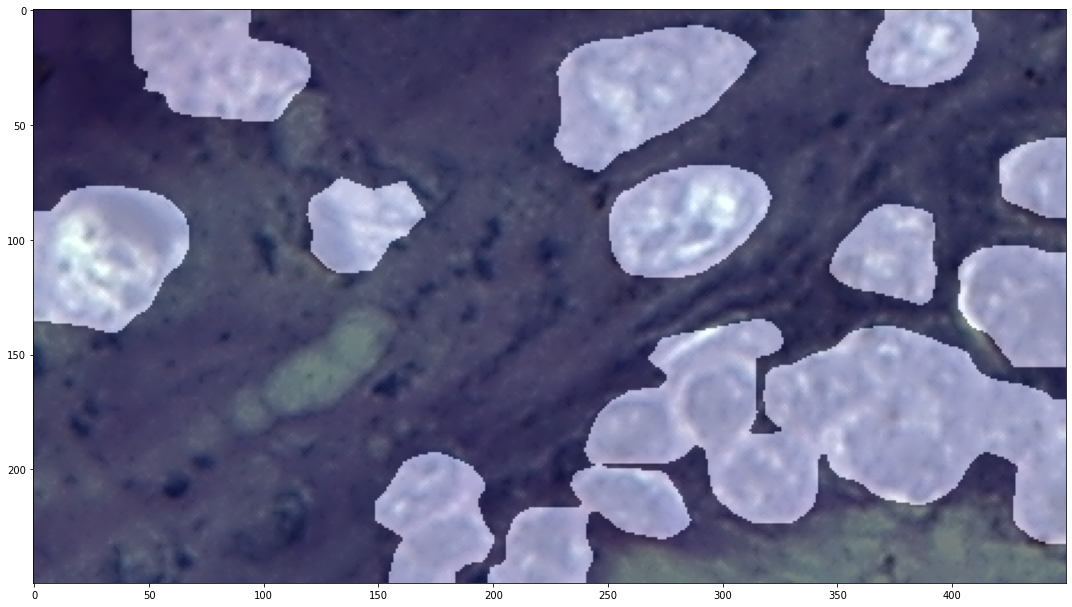

In [16]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

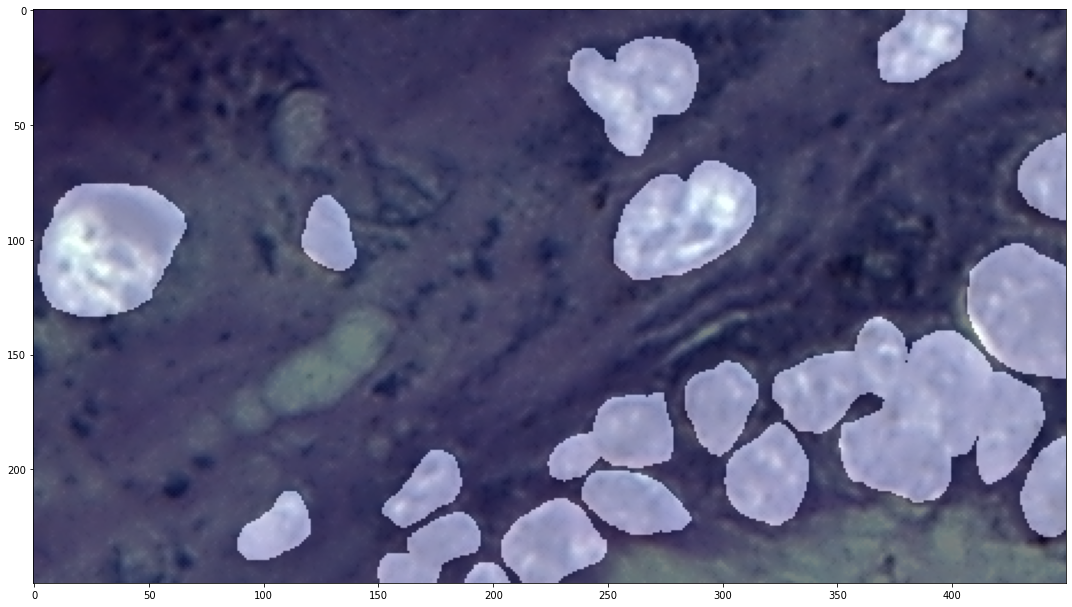

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')
result = mmcv.imread('ToTrain/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

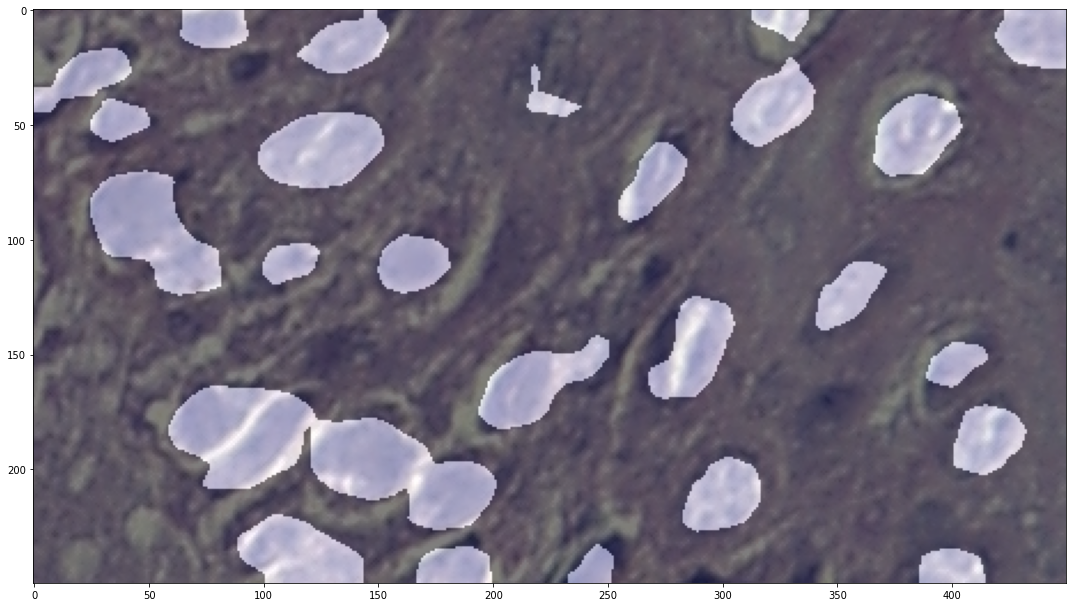

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

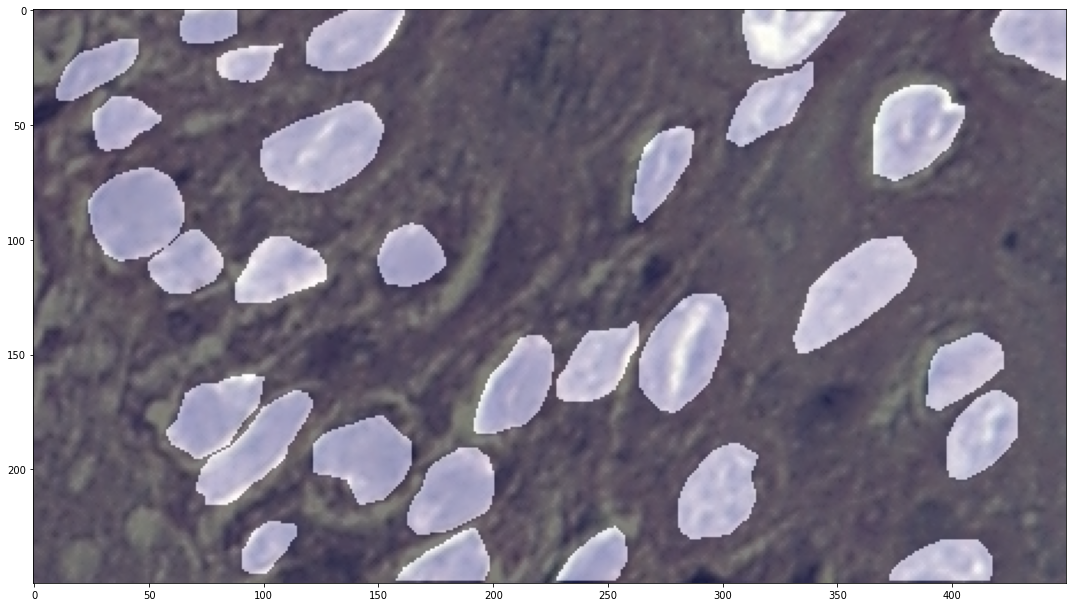

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')
result = mmcv.imread('ToTrain/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [20]:
!rm -rf segmentation
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
   creating: segmentation/annotations/healthy/
  inflating: segmentation/annotations/healthy/image003-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi3.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi4.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi5.tif  
  inflating: segmentation/annotations/healthy/image004-roi1.tif  
  inflating: segmentation/annotations/healthy/image004-roi2.tif  
  inflating: segmentation/annotations/healthy/image004-roi3.tif  
  inflating: segmentation/annotations/healthy/image004-roi4.tif  
  inflating: segmentation/annotations/healthy/image004-roi5.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi1.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi3.tif  
  inflating: segmentation/annotations/healthy/im

In [21]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/psp_150/raw_res/' + img_path[20:]))

In [22]:
%rm -rf ./work_dirs/psp_150/raw_res/

In [23]:
%mkdir ./work_dirs/psp_150/raw_res/
%mkdir ./work_dirs/psp_150/raw_res/healthy
%mkdir ./work_dirs/psp_150/raw_res/mild
%mkdir ./work_dirs/psp_150/raw_res/moderate
%mkdir ./work_dirs/psp_150/raw_res/severe

In [24]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path}', predict_img)

In [25]:
%matplotlib inline
import json

file = open('./work_dirs/psp_150/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

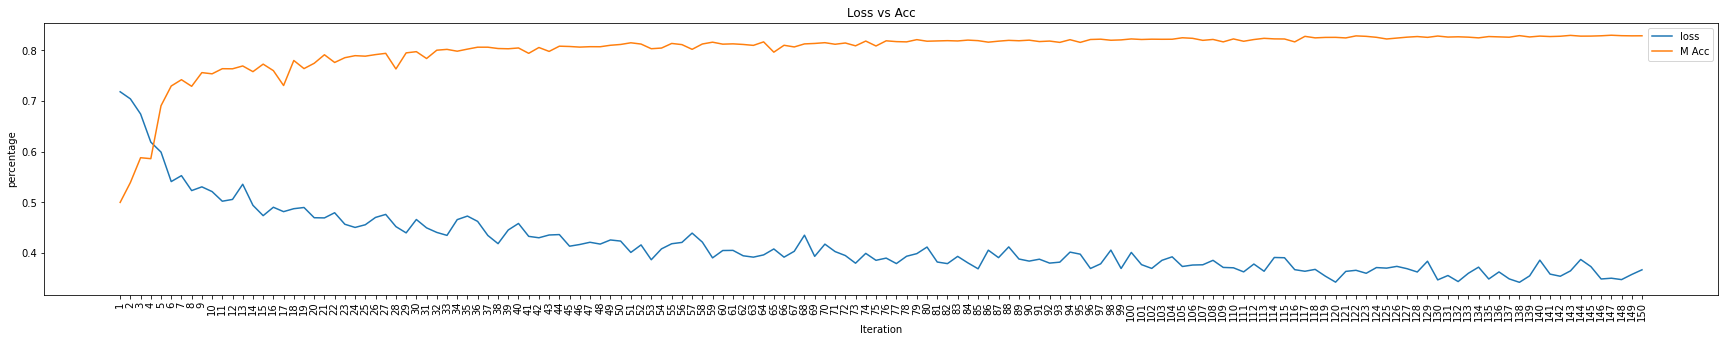

In [33]:
plt.figure(figsize=(30, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('./work_dirs/psp_150/Loss_vs_Acc_Graph.png')
plt.show()

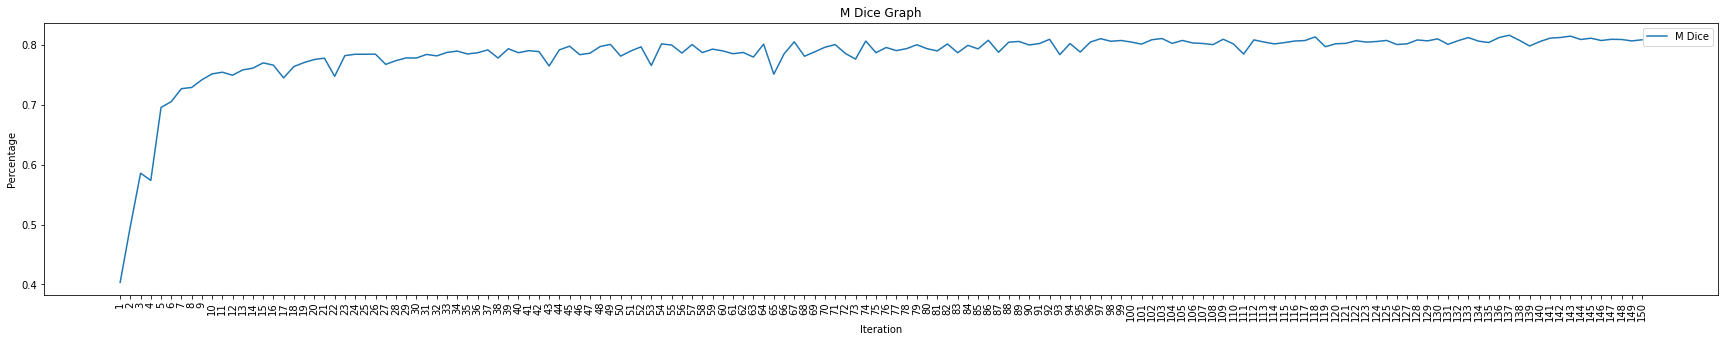

In [34]:
plt.figure(figsize=(30, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('./work_dirs/psp_150/M_Dice_Graph.png')
plt.show()
plt.close()

In [28]:
!zip -r pspNet_150.zip ./work_dirs/psp_150/

  adding: work_dirs/psp_150/ (stored 0%)
  adding: work_dirs/psp_150/epoch_10.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_60.pth (deflated 8%)
  adding: work_dirs/psp_150/M_Dice_Graph.png (deflated 9%)
  adding: work_dirs/psp_150/epoch_110.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_140.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_70.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_150.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_50.pth (deflated 8%)
  adding: work_dirs/psp_150/epoch_20.pth (deflated 8%)
  adding: work_dirs/psp_150/raw_res/ (stored 0%)
  adding: work_dirs/psp_150/raw_res/mild/ (stored 0%)
  adding: work_dirs/psp_150/raw_res/mild/image018-roi6.tif (deflated 3%)
  adding: work_dirs/psp_150/raw_res/mild/image018-roi3.tif (deflated 3%)
  adding: work_dirs/psp_150/raw_res/mild/image006-roi1.tif (deflated 4%)
  adding: work_dirs/psp_150/raw_res/mild/image008-roi1.tif (deflated 9%)
  adding: work_dirs/psp_150/raw_res/mild/image021-roi6.tif (de

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')

In [30]:
#!cp pspNet_150.zip /content/drive/MyDrive/TCC/